In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
from rubin_sim.maf import radar
import os

from matplotlib.legend_handler import HandlerErrorbar

In [2]:
def norm_df(
    df,
    runs,
    cols,
    norm_run="baseline",
    invert_cols=None,
    reverse_cols=None,
    run_label="run_name",
    mag_cols=[],
):
    """
    Normalize values in a dataframe to a given run
    Parameters
    ----------
    df : pandas.DataFrame
        The input data frame
    runs : list of str
        A list of run numes
    cols : list of str
        A list of columns in df to use
    norm_run : str
        The row to use to normalize things to
    invert_cols : list of str
        A list of column names that should be inverted (e.g., columns that
        are uncertainties and are better with a smaller value)
    reverse_cols : list of str
        Columns to reverse (e.g., magnitudes)
    run_label : str (run_name)
        The column that has run names
    mag_cols : list of str
        Columns that are in magnitudes
    """
    indices = [np.max(np.where(df.index == name)[0]) for name in runs]
    out_df = df[cols].iloc[indices].copy()
    if reverse_cols is not None:
        for colname in reverse_cols:
            out_df[colname] = -out_df[colname]
    if invert_cols is not None:
        for colname in invert_cols:
            out_df[colname] = 1.0 / out_df[colname]
    if norm_run is not None:
        indx = np.max(np.where(out_df.index == norm_run)[0])
        for col in out_df.columns:
            # maybe just check that it's not a
            if col != "run_name":
                if (col in mag_cols) | (mag_cols == "all"):
                    out_df[col] = 1.0 + (out_df[col] - out_df[col].iloc[indx])
                else:
                    out_df[col] = (
                        1.0
                        + (out_df[col] - out_df[col].iloc[indx])
                        / out_df[col].iloc[indx]
                    )
    return out_df

In [3]:

data_loaded = pd.read_hdf('summary.h5')
data_loaded.shape

(60, 79133)

In [4]:
#[col for col in data_loaded.columns if 'LVDwarfs' in col]
#[col for col in data_loaded.columns if 'KNePop' in col and 'Total detected' in col and 'ztfrest_simple ' in col and 'DD' in col ]
[col for col in data_loaded.columns if 'Footprint' in col ]

['FootprintFraction N year 1 g and night < 365 HealpixSlicer',
 'FootprintFraction N year 1 i and night < 365 HealpixSlicer',
 'FootprintFraction N year 1 r and night < 365 HealpixSlicer',
 'FootprintFraction N year 1 u and night < 365 HealpixSlicer',
 'FootprintFraction N year 1 y and night < 365 HealpixSlicer',
 'FootprintFraction N year 1 z and night < 365 HealpixSlicer',
 'Sum GalplaneFootprintMetric_bonito_sfr_map_Tau_11_0 HealpixSlicer',
 'Sum GalplaneFootprintMetric_bonito_sfr_map_Tau_20_0 HealpixSlicer',
 'Sum GalplaneFootprintMetric_bonito_sfr_map_Tau_2_0 HealpixSlicer',
 'Sum GalplaneFootprintMetric_bonito_sfr_map_Tau_46_5 HealpixSlicer',
 'Sum GalplaneFootprintMetric_bonito_sfr_map_Tau_5_0 HealpixSlicer',
 'Sum GalplaneFootprintMetric_bonito_sfr_map_Tau_73_0 HealpixSlicer',
 'Sum GalplaneFootprintMetric_bonito_sfr_map_n_obs HealpixSlicer',
 'Sum GalplaneFootprintMetric_bonito_sfr_map_n_obs_priority HealpixSlicer',
 'Sum GalplaneFootprintMetric_clementini_stellarpops_map_Tau_

In [5]:
# Pull out the metrics we are interested in and define simple names

name_dict = {'FootprintFraction N year 1 u and night < 365 HealpixSlicer': 'Y1,u',
            'FootprintFraction N year 1 g and night < 365 HealpixSlicer': 'Y1,g',
            'FootprintFraction N year 1 r and night < 365 HealpixSlicer': 'Y1,r',

            'FootprintFraction N year 1 i and night < 365 HealpixSlicer': 'Y1,i',
    'best18k Parallax fiveSigmaDepth, filter, seeingFwhmGeom, ra_pi_amp, dec_pi_amp HealpixSlicer': 'parallax best 18k',
            'best18k properMotion HealpixSlicer': 'proper motion best 18k',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 20_30 days UserPointsSlicer': '20-30d microlensing\ndetection',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 60_90 days UserPointsSlicer': '60-90d microlensing\ndetection',
            'fONv MedianNvis fO HealpixSlicer': 'fO N vis',
            'Total detected SNNSNMetric_reducen_sn DDF excluded HealpixSlicer': 'SNe, N',
             'Median SNNSNMetric_reducezlim DDF excluded HealpixSlicer': 'SNe, zlim',
            '3x2ptFoM Exgalm5WithCuts i band non-DD year 10 HealpixSlicer': '3x2 i-band',
            'Median WeakLensingNvisits gri band non-DD HealpixSlicer': 'WL Nvis \ni-band',
            'Total detected KNePopMetric_all_ztfrest_simple all models UserPointsSlicer': 'KNe ZTF simple',
            'Total detected KNePopMetric_single_ztfrest_simple single model UserPointsSlicer': 'KNe single model',
            'Sum PrestoKNe_score_p UserPointsSlicer': 'KNe Score, P',
            'Total detected XRBPopMetric_early_detect UserPointsSlicer': 'XRB\nearly detect',
            'VolumeSum Brown Dwarf, L7 HealpixSlicer': 'Brown Dwarf Vol',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO bright',
            'CumulativeCompleteness H <= 22.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO faint',
            'CumulativeCompleteness H <= 6.000000 DiscoveryNChances TNO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'TNO',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances MBA 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'MBA',
            'CumulativeCompleteness H <= 18.000000 DiscoveryNChances Trojan 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'Trojan',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances Vatira 1 quad in 1 night detection loss MoObjSlicer': 'Vatira',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances PHA 1 quad in 1 night detection loss MoObjSlicer': 'PHA, quad'}
            
# drop in the units for the columns
units = {'parallax best 18k': 'mas',
         'proper motion best 18k': 'mas/yr',
         '20-30d microlensing\ndetection': 'fraction', 
         '60-90d microlensing\ndetection': 'fraction', 
         'fO N vis' : '', 
         'SNe, N': '', 
         'SNe, zlim': '', 
         '3x2 i-band': 'score', 
         'WL Nvis \ni-band': '', 
         'KNe ZTF simple': 'N', 
         'KNe single model': 'N',
         'KNe Score, P': 'score',
         'XRB\nearly detect': 'N', 
         'Brown Dwarf Vol': 'pc^3', 
         'NEO bright': 'fraction', 
         'NEO faint': 'fraction', 
         'TNO': 'fraction', 
         'MBA':'fraction',
         'Trojan': 'fraction',
         'Vatira': 'fraction',
         'PHA, quad': 'fraction',
         'Y1,u': '',
         'Y1,g': '',
         'Y1,r': '',
         'Y1,i': '',
        }

# If columns are uncertainties, we want to plot them backwards
invert_cols = ['parallax best 18k', 'proper motion best 18k']
# If columns are mags or fractions, we want to plot differences, not fractional differences.
mag_cols = ['20-30d microlensing\ndetection', '60-90d microlensing\ndetection','SNe, zlim',
            'NEO bright', 'NEO faint', 'TNO', 'Vatira', 'MBA', 'Trojan']

data = pd.DataFrame()
for key in name_dict:
    data[name_dict[key]] = data_loaded[key]
    

mag_dict = {'Median CoaddM5 g HealpixSlicer': 'g',
 'Median CoaddM5 i HealpixSlicer': 'i',
 'Median CoaddM5 r HealpixSlicer': 'r',
 'Median CoaddM5 u HealpixSlicer': 'u',
 'Median CoaddM5 y HealpixSlicer': 'y',
 'Median CoaddM5 z HealpixSlicer': 'z'}

mag_data = pd.DataFrame()
for key in mag_dict:
    mag_data[mag_dict[key]] = data_loaded[key]
    
    
    
ddf_dict = {'Sum SNNSNMetric DD:COSMOS_reducen_sn DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN COSMOS',
           'Sum SNNSNMetric DD:ECDFS_reducen_sn DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ECDFS',
           'Sum SNNSNMetric DD:EDFS_reducen_sn DD:EDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN EDFS',
           'Sum SNNSNMetric DD:ELAISS1_reducen_sn DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ELAISS1',
           'Sum SNNSNMetric DD:XMM_LSS_reducen_sn DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN XMM_LSS',
            
           'Median SNNSNMetric DD:COSMOS_reducezlim DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer': 'zlim COSMOS',
            'Median SNNSNMetric DD:ECDFS_reducezlim DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim ECDFS',
            'Median SNNSNMetric DD:EDFS_reducezlim DD:EDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim EDFS',
            'Median SNNSNMetric DD:ELAISS1_reducezlim DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer': 'zlim ELAISS1',
            'Median SNNSNMetric DD:XMM_LSS_reducezlim DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer': 'zlim XMM_LSS',
            
           'Total detected KNePopMetric_DD:COSMOS_ztfrest_simple DD:COSMOS UserPointsSlicer': 'Kne COSMOS',
         'Total detected KNePopMetric_DD:ECDFS_ztfrest_simple DD:ECDFS UserPointsSlicer': 'Kne ECDFS',
 'Total detected KNePopMetric_DD:EDFS_ztfrest_simple DD:EDFS UserPointsSlicer': 'Kne EDFS',
 'Total detected KNePopMetric_DD:ELAISS1_ztfrest_simple DD:ELAISS1 UserPointsSlicer': 'Kne ELAISS1',
 'Total detected KNePopMetric_DD:WFD_ztfrest_simple DD:WFD UserPointsSlicer': 'Kne WFD',
 'Total detected KNePopMetric_DD:XMM_LSS_ztfrest_simple DD:XMM_LSS UserPointsSlicer': 'Kne XMM_LSS',
            
            'Median DD:COSMOS NVisits all bands HealpixSubsetSlicer':'N COSMOS',
 'Median DD:ECDFS NVisits all bands HealpixSubsetSlicer': 'N ECDFS',
 'Median DD:EDFS NVisits all bands HealpixSubsetSlicer': 'N EDFS',
 'Median DD:ELAISS1 NVisits all bands HealpixSubsetSlicer': 'N ELAISS1',
 'Median DD:WFD NVisits all bands HealpixSubsetSlicer': 'N WFD',
 'Median DD:XMM_LSS NVisits all bands HealpixSubsetSlicer': 'N XMM_LSS', 
           }

ddf_data = pd.DataFrame()
for key in ddf_dict:
    ddf_data[ddf_dict[key]] = data_loaded[key]
 
gaps_dict = {}
for filtername in 'ugrizy':
    for times in [3,7,24]:
        gaps_dict['Mean N gaps in %s at %ihr in top 18k Gaps_%ihr %s band HealpixSlicer'% (filtername, times, times, filtername)] = 'gaps %s %i' % (filtername, times)
        #gaps_dict['Mean Gaps_%ihr %s band HealpixSlicer' % (times, filtername)] = 'gaps %s %i' % (filtername, times)
        
gaps_data = pd.DataFrame()
for key in gaps_dict:
    gaps_data[gaps_dict[key]] = data_loaded[key]

In [6]:
#data['KNe single model'] # data['KNe ZTF simple']

In [7]:
# A bit of a mystery why baseline_v3.0_10yrs is so much better. 
# The KNe ZTF simple and KNe single model don't seem to
# be particularly well correlated. Seems like it has to be an MJD_start bug somewhere, but I can't find it.
#data['KNe ZTF simple']

In [8]:
mag_data

g          i          r          u  \
baseline_v2.0_10yrs                26.733479  26.218659  26.755971  25.818916   
baseline_v2.1_10yrs                26.736248  26.252054  26.781543  25.751969   
baseline_v2.2_10yrs                26.753646  26.290929  26.835430  25.724699   
baseline_v3.0_10yrs                26.688123  26.264600  26.818287  25.668262   
baseline_v3.2_10yrs                26.678103  26.295888  26.807880  25.622696   
baseline_v3.3_10yrs                26.786124  26.451047  26.929058  25.338704   
ddf_half_v3.3_10yrs                26.796594  26.445799  26.917266  25.338355   
ddf_loaded_fl15_v3.3_10yrs         26.789489  26.445092  26.925141  25.332942   
ddf_loaded_fl1_v3.3_10yrs          26.794278  26.469092  26.945913  25.355402   
ddf_loaded_fl2_v3.3_10yrs          26.799025  26.464460  26.935946  25.339882   
ddf_loaded_fl4_v3.3_10yrs          26.789380  26.458189  26.933981  25.338243   
ddf_loaded_fl8_v3.3_10yrs          26.789297  26.453259  26.924372  25.336893   
ddf_loaded_half_fl15_v3.3_10yrs    26.782160  26.446405  26.921128  25.341961   
ddf_loaded_half_fl1_v3.3_10yrs     26.795435  26.465572  26.941825  25.355528   
ddf_loaded_half_fl2_v3.3_10yrs     26.787868  26.470956  26.928336  25.341960   
ddf_loaded_half_fl4_v3.3_10yrs     26.795975  26.450317  26.925674  25.340957   
ddf_loaded_half_fl8_v3.3_10yrs     26.793016  26.450616  26.923269  25.334716   
m2_baseline_v3.3_10yrs             26.787686  26.448831  26.926336  25.337031   
mw_roll_all_v3.3_10yrs             26.795191  26.451114  26.927601  25.330616   
noroll_v3.3_10yrs                  26.823274  26.474125  26.952263  25.369015   
retro_baseline_v2.0_10yrs          26.835006  26.308518  26.850968  25.707301   
roll_mid1_const_season2v3.3_10yrs  26.793883  26.446566  26.930509  25.345064   
roll_mid1_const_season4v3.3_10yrs  26.789608  26.448766  26.927060  25.341858   
roll_mid1_const_season6v3.3_10yrs  26.781815  26.450788  26.932305  25.351820   
roll_mid1_const_season_v3.3_10yrs  26.795968  26.452969  26.935747  25.346973   
roll_mid2_const_season2v3.3_10yrs  26.801576  26.460014  26.938625  25.346807   
roll_mid2_const_season4v3.3_10yrs  26.791726  26.453583  26.936587  25.348860   
roll_mid2_const_season6v3.3_10yrs  26.791726  26.453583  26.936587  25.348860   
roll_mid2_const_season_v3.3_10yrs  26.802812  26.454651  26.936118  25.348566   
roll_mid3_const_season2v3.3_10yrs  26.789528  26.442204  26.927672  25.331700   
roll_mid3_const_season4v3.3_10yrs  26.785975  26.446239  26.928148  25.329838   
roll_mid3_const_season6v3.3_10yrs  26.791006  26.445979  26.928684  25.340455   
roll_mid3_const_season_v3.3_10yrs  26.786124  26.451047  26.929058  25.338704   
rolling_phased_ps_-182_v3.3_10yrs  26.774524  26.425355  26.905069  25.327021   
rolling_phased_ps_0_v3.3_10yrs     26.795968  26.452969  26.935747  25.346973   
rolling_phased_ps_182_v3.3_10yrs   26.748865  26.397450  26.872820  25.298297   
twenty_nr_cycles_4_v3.3_20yrs      27.187959  26.833880  27.318583  25.757966   
twenty_nr_cycles_8_v3.3_20yrs      27.178517  26.823413  27.306024  25.752214   
twenty_nr_cycles_9_v3.3_20yrs      27.177244  26.823336  27.303083  25.743486   
u_exp_25_v3.3_10yrs                26.796624  26.452875  26.931661  25.183287   
u_exp_30_v3.3_10yrs                26.786124  26.451047  26.929058  25.338704   
u_exp_40_v3.3_10yrs                26.777858  26.438660  26.911192  25.567787   
u_exp_50_v3.3_10yrs                26.778493  26.427289  26.905833  25.728985   
u_exp_60_v3.3_10yrs                26.755575  26.421530  26.893911  25.857000   
weather_cloudso0v3.3_10yrs         26.786124  26.451047  26.929058  25.338704   
weather_cloudso10v3.3_10yrs        26.808930  26.464835  26.949119  25.343064   
weather_cloudso12v3.3_10yrs        26.803511  26.464447  26.947419  25.346643   
weather_cloudso14v3.3_10yrs        26.802619  26.462864  26.943148  25.333133   
weather_cloudso16v3.3_10yrs        26.792374  26.475741  26.952561  25.333

In [9]:
ddf_data
#ddf_data = ddf_data.reindex(new_ind)

N SN COSMOS   N SN ECDFS    N SN EDFS  \
baseline_v2.0_10yrs                 638.253284   586.826209   974.231557   
baseline_v2.1_10yrs                 548.479625   545.669910   875.981802   
baseline_v2.2_10yrs                 708.239238   685.202422  1067.553931   
baseline_v3.0_10yrs                 955.159293   799.584601  1266.961769   
baseline_v3.2_10yrs                 971.481238   868.593513  1528.851192   
baseline_v3.3_10yrs                1047.540991   915.629883  1676.207855   
ddf_half_v3.3_10yrs                1331.755939  1237.191454  1964.187218   
ddf_loaded_fl15_v3.3_10yrs         1292.226879  1251.248828  1985.001550   
ddf_loaded_fl1_v3.3_10yrs           918.401939   809.686410  1460.267361   
ddf_loaded_fl2_v3.3_10yrs          1056.919391   966.359772  1711.451567   
ddf_loaded_fl4_v3.3_10yrs          1145.218124  1126.079281  1836.937938   
ddf_loaded_fl8_v3.3_10yrs          1207.601771  1193.270364  1882.605355   
ddf_loaded_half_fl15_v3.3_10yrs    1398.174667  1341.650774  2095.101551   
ddf_loaded_half_fl1_v3.3_10yrs     1180.615232  1050.249588  1692.825415   
ddf_loaded_half_fl2_v3.3_10yrs     1266.557005  1195.791835  1839.102573   
ddf_loaded_half_fl4_v3.3_10yrs     1327.347213  1243.787145  1919.917005   
ddf_loaded_half_fl8_v3.3_10yrs     1370.801867  1292.419860  2016.608449   
m2_baseline_v3.3_10yrs             1027.365709   904.367407  1665.826468   
mw_roll_all_v3.3_10yrs             1097.386480   913.771044  1719.030839   
noroll_v3.3_10yrs                  1138.730554  1112.694500  1784.680054   
retro_baseline_v2.0_10yrs           633.216869   678.859654  1098.712998   
roll_mid1_const_season2v3.3_10yrs  1038.060894   970.749672  1685.610884   
roll_mid1_const_season4v3.3_10yrs  1042.019012   949.695798  1664.453131   
roll_mid1_const_season6v3.3_10yrs  1094.444344   916.101201  1655.629407   
roll_mid1_const_season_v3.3_10yrs  1071.261572   936.511906  1660.333408   
roll_mid2_const_season2v3.3_10yrs  1085.602911  1003.195274  1723.922142   
roll_mid2_const_season4v3.3_10yrs  1108.622002   969.992421  1687.163733   
roll_mid2_const_season6v3.3_10yrs  1108.622002   969.992421  1687.163733   
roll_mid2_const_season_v3.3_10yrs  1083.536524   983.101425  1703.800880   
roll_mid3_const_season2v3.3_10yrs  1017.319311  1026.526220  1676.367698   
roll_mid3_const_season4v3.3_10yrs  1035.980626   997.309834  1647.310199   
roll_mid3_const_season6v3.3_10yrs  1071.921933   985.015058  1674.556167   
roll_mid3_const_season_v3.3_10yrs  1047.540991   915.629883  1676.207855   
rolling_phased_ps_-182_v3.3_10yrs          NaN          NaN          NaN   
rolling_phased_ps_0_v3.3_10yrs             NaN          NaN          NaN   
rolling_phased_ps_182_v3.3_10yrs           NaN          NaN          NaN   
twenty_nr_cycles_4_v3.3_20yrs      1975.371845  1980.396938  3522.213439   
twenty_nr_cycles_8_v3.3_20yrs      1903.471417  1848.864436  3429.465766   
twenty_nr_cycles_9_v3.3_20yrs      1902.613560  1904.238919  3411.610397   
u_exp_25_v3.3_10yrs                1028.512618   933.950571  1662.097012   
u_exp_30_v3.3_10yrs                1047.540991   915.629883  1676.207855   
u_exp_40_v3.3_10yrs                1023.108466   911.914939  1649.249890   
u_exp_50_v3.3_10yrs                1033.148437   895.611344  1657.572311   
u_exp_60_v3.3_10yrs                1015.914561   876.660847  1626.861429   
weather_cloudso0v3.3_10yrs         1047.540991   915.629883  1676.207855   
weather_cloudso10v3.3_10yrs        1000.963663   854.674796  1519.249384   
weather_cloudso12v3.3_10yrs         976.604604   860.153445  1503.413384   
weather_cloudso14v3.3_10yrs        1016.625488   811.029806  1412.536851   
weather_cloudso16v3.3_10yrs         952.170228   914.965461  1520.683756   
weather_cloudso18v3.3_10yrs         989.669243   858.180414  1404.052534   
weather_cloudso1v3.3_10yrs          999.154984   932.821124  1646.194297   
weather_cloudso20v3.3_10yrs         996.688184   828.383842  1415.782663   
weather

In [10]:
gaps_data

gaps u 3  gaps u 7  gaps u 24  gaps g 3  \
baseline_v2.0_10yrs                0.559565  0.096983   2.681121  0.501515   
baseline_v2.1_10yrs                0.601110  0.097077   2.961440  0.621392   
baseline_v2.2_10yrs                0.633655  0.187066   3.622465  0.399776   
baseline_v3.0_10yrs                0.257192  0.257425   3.984706  0.213736   
baseline_v3.2_10yrs                0.140020  0.100247   3.084814  0.605912   
baseline_v3.3_10yrs                0.185620  0.113349   3.149718  0.167436   
ddf_half_v3.3_10yrs                0.187998  0.125892   3.565813  0.203478   
ddf_loaded_fl15_v3.3_10yrs         0.182217  0.102998   3.277242  0.129529   
ddf_loaded_fl1_v3.3_10yrs          0.176062  0.131161   3.702989  0.141605   
ddf_loaded_fl2_v3.3_10yrs          0.183336  0.092414   3.621765  0.138434   
ddf_loaded_fl4_v3.3_10yrs          0.206276  0.116147   3.453350  0.135637   
ddf_loaded_fl8_v3.3_10yrs          0.179279  0.124120   3.390544  0.141838   
ddf_loaded_half_fl15_v3.3_10yrs    0.216814  0.120670   3.334312  0.132839   
ddf_loaded_half_fl1_v3.3_10yrs     0.202219  0.146314   3.804168  0.147760   
ddf_loaded_half_fl2_v3.3_10yrs     0.189584  0.126218   3.466499  0.143470   
ddf_loaded_half_fl4_v3.3_10yrs     0.190376  0.105283   3.565207  0.172518   
ddf_loaded_half_fl8_v3.3_10yrs     0.166923  0.127943   3.325640  0.148692   
m2_baseline_v3.3_10yrs             0.218445  0.149904   3.320185  0.226698   
mw_roll_all_v3.3_10yrs             0.185341  0.110318   3.425001  0.134937   
noroll_v3.3_10yrs                  0.162587  0.098522   2.529538  0.178953   
retro_baseline_v2.0_10yrs          0.572574  0.091528   3.893971  0.573553   
roll_mid1_const_season2v3.3_10yrs  0.199562  0.107381   3.052129  0.148086   
roll_mid1_const_season4v3.3_10yrs  0.187952  0.124446   3.090968  0.144682   
roll_mid1_const_season6v3.3_10yrs  0.177927  0.099734   3.292675  0.168135   
roll_mid1_const_season_v3.3_10yrs  0.185480  0.114841   2.980370  0.170746   
roll_mid2_const_season2v3.3_10yrs  0.188931  0.106542   2.772649  0.158577   
roll_mid2_const_season4v3.3_10yrs  0.180911  0.099594   3.135777  0.171726   
roll_mid2_const_season6v3.3_10yrs  0.180911  0.099594   3.135777  0.171726   
roll_mid2_const_season_v3.3_10yrs  0.182543  0.107754   2.860353  0.159883   
roll_mid3_const_season2v3.3_10yrs  0.210146  0.116427   3.186040  0.149625   
roll_mid3_const_season4v3.3_10yrs  0.188698  0.125845   3.189724  0.145242   
roll_mid3_const_season6v3.3_10yrs  0.183522  0.112323   3.104863  0.157738   
roll_mid3_const_season_v3.3_10yrs  0.185620  0.113349   3.149718  0.167436   
rolling_phased_ps_-182_v3.3_10yrs       NaN       NaN        NaN       NaN   
rolling_phased_ps_0_v3.3_10yrs          NaN       NaN        NaN       NaN   
rolling_phased_ps_182_v3.3_10yrs        NaN       NaN        NaN       NaN   
twenty_nr_cycles_4_v3.3_20yrs      0.257425  0.146920   5.793304  0.299576   
twenty_nr_cycles_8_v3.3_20yrs      0.256773  0.174570   6.989835  0.265818   
twenty_nr_cycles_9_v3.3_20yrs      0.261389  0.178720   6.968527  0.253042   
u_exp_25_v3.3_10yrs                0.206043  0.107148   3.186133  0.120343   
u_exp_30_v3.3_10yrs                0.185620  0.113349   3.149718  0.167436   
u_exp_40_v3.3_10yrs                0.171259  0.092367   4.006901  0.152282   
u_exp_50_v3.3_10yrs                0.191122  0.112044   3.651000  0.129529   
u_exp_60_v3.3_10yrs                0.212804  0.134005   4.058050  0.125146   
weather_cloudso0v3.3_10yrs         0.185620  0.113349   3.149718  0.167436   
weather_cloudso10v3.3_10yrs        0.177088  0.084441   3.953094  0.164545   
weather_cloudso12v3.3_10yrs        0.198489  0.152282   3.822912  0.139274   
weather_cloudso14v3.3_10yrs        0.205763  0.133772   4.194573  0.160582   
weather_cloudso16v3.3_10yrs        0.182823  0.122721   3.877232  0.163333   
weather_cloudso18v3.3_10yrs        0.227911  0.091341   4.267870  0.192708   
weather_cloudso1v3.3_10yrs         0.186973  0.090502   3

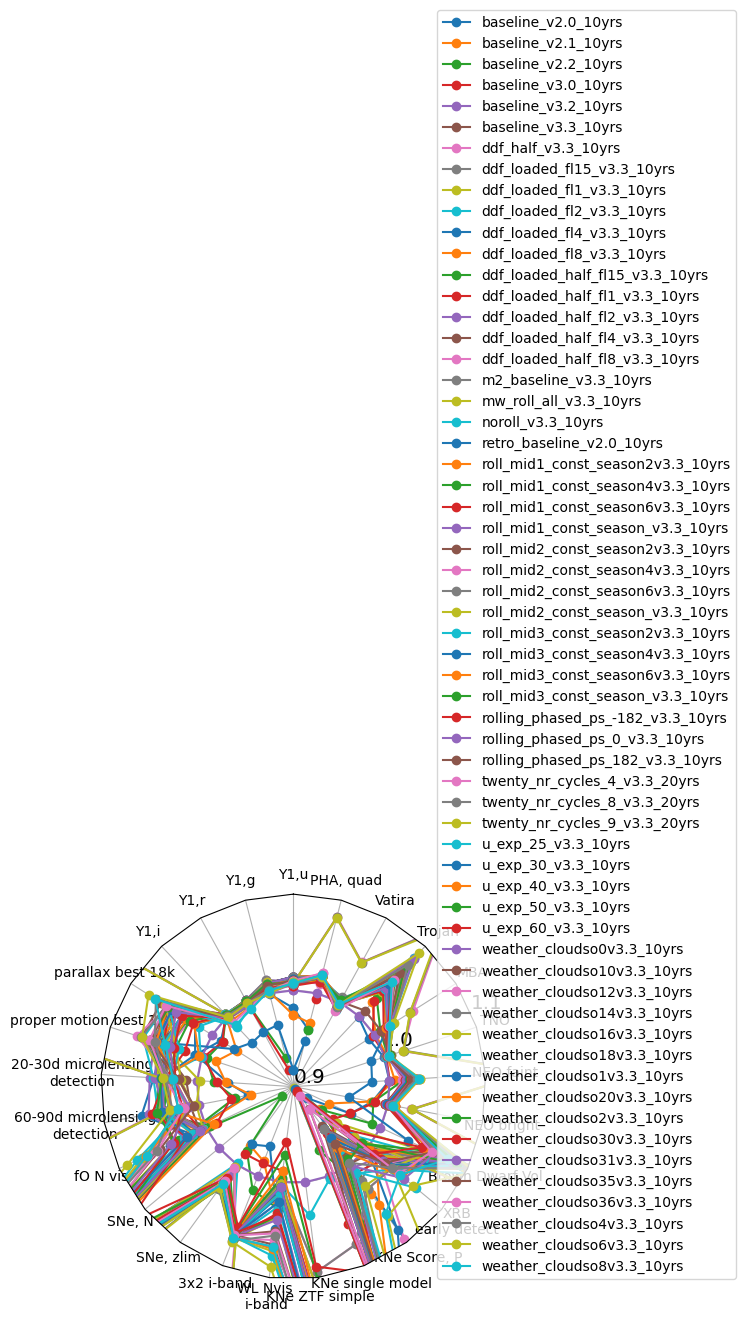

In [11]:
runs = [run for run in data.index ]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.2_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

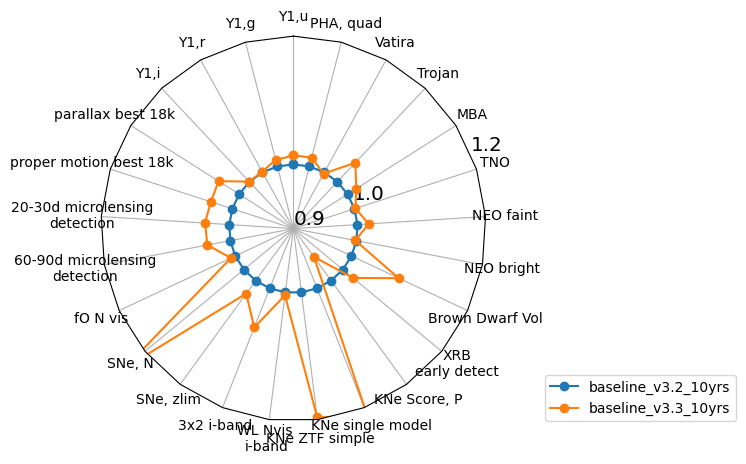

In [12]:
runs = ['baseline_v3.2_10yrs', 'baseline_v3.3_10yrs' ]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.2_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.2], bbox_to_anchor=(1.65, 0))

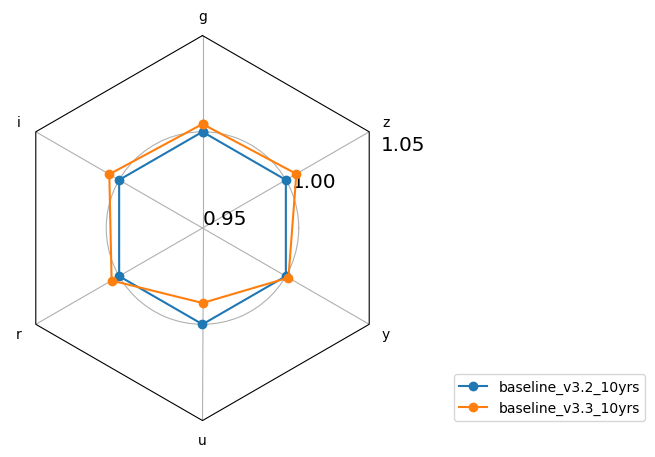

In [13]:
runs = ['baseline_v3.2_10yrs', 'baseline_v3.3_10yrs' ]
ndata = norm_df(mag_data, runs, cols=mag_data.columns.values.tolist(),
                 mag_cols = mag_cols, norm_run='baseline_v3.2_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.95, 1.0, 1.05], bbox_to_anchor=(1.65, 0))

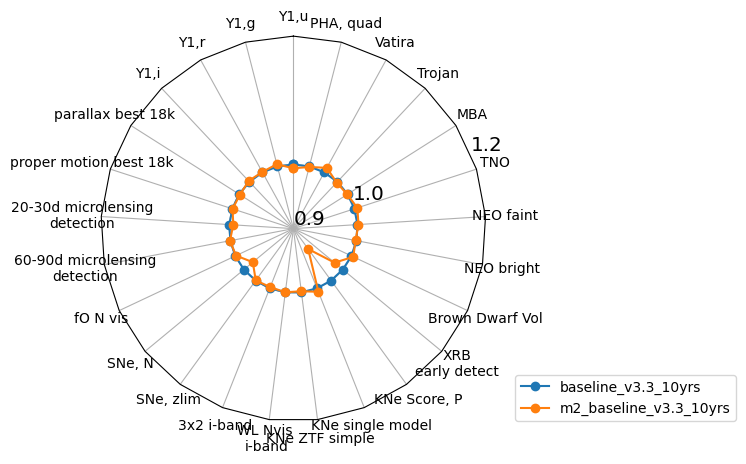

In [14]:
# Look at difference between cluster and Apple chips
runs = ['baseline_v3.3_10yrs', 'm2_baseline_v3.3_10yrs' ]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.2], bbox_to_anchor=(1.65, 0))

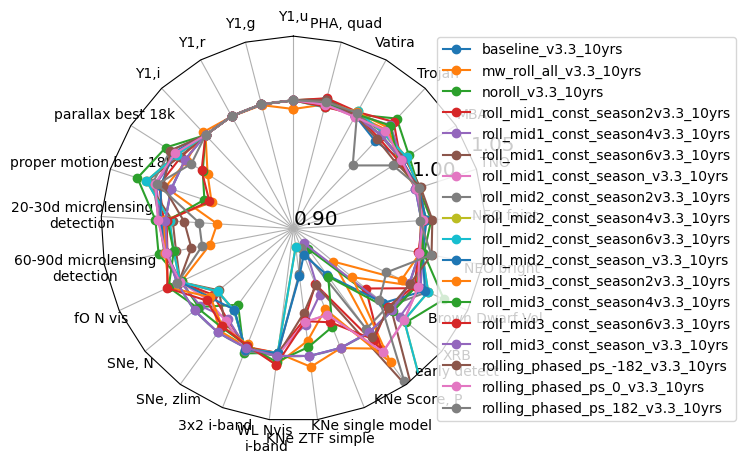

In [15]:
# various rolling
runs = ['baseline_v3.3_10yrs'] + [run for run in data.index if 'roll' in run]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.90, 1.0, 1.05], bbox_to_anchor=(1.65, 0))

In [16]:


times = ['retro_baseline_v2.0_10yrs', 'baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs',
        'baseline_v3.0_10yrs',  'baseline_v3.2_10yrs', 'baseline_v3.3_10yrs']

sub_data = data.reindex(labels=times)
sub_ddf = ddf_data.reindex(labels=times)
sub_mag = mag_data.reindex(labels=times)
sub_gaps = gaps_data.reindex(labels=times)
sub_data



Y1,u      Y1,g      Y1,r      Y1,i  \
retro_baseline_v2.0_10yrs  0.893276  0.949104  0.960964  0.958616   
baseline_v2.0_10yrs        0.955776  0.981594  0.994441  0.997035   
baseline_v2.1_10yrs        0.948661  0.984188  0.996912  0.999012   
baseline_v2.2_10yrs        0.871233  0.914268  0.993947  0.998023   
baseline_v3.0_10yrs        0.813058  0.901174  0.993823  0.999135   
baseline_v3.2_10yrs        0.973633  0.982335  0.996170  0.995800   
baseline_v3.3_10yrs        0.987305  0.992712  0.997529  0.996294   

                           parallax best 18k  proper motion best 18k  \
retro_baseline_v2.0_10yrs           0.804328                0.176701   
baseline_v2.0_10yrs                 0.791058                0.184088   
baseline_v2.1_10yrs                 0.806910                0.188258   
baseline_v2.2_10yrs                 0.792958                0.186345   
baseline_v3.0_10yrs                 0.792666                0.185683   
baseline_v3.2_10yrs                 0.782518                0.185369   
baseline_v3.3_10yrs                 0.753823                0.179042   

                           20-30d microlensing\ndetection  \
retro_baseline_v2.0_10yrs                          0.0878   
baseline_v2.0_10yrs                                0.3119   
baseline_v2.1_10yrs                                0.3141   
baseline_v2.2_10yrs                                0.3268   
baseline_v3.0_10yrs                                0.3232   
baseline_v3.2_10yrs                                0.3437   
baseline_v3.3_10yrs                                0.3817   

                           60-90d microlensing\ndetection  fO N vis  \
retro_baseline_v2.0_10yrs                          0.1568     848.0   
baseline_v2.0_10yrs                                0.4348     839.0   
baseline_v2.1_10yrs                                0.4319     838.0   
baseline_v2.2_10yrs                                0.4487     830.0   
baseline_v3.0_10yrs                                0.4528     795.0   
baseline_v3.2_10yrs                                0.4869     805.0   
baseline_v3.3_10yrs                                0.5233     811.0   

                                  SNe, N  ...  KNe Score, P  \
retro_baseline_v2.0_10yrs   97124.012102  ...    202.730488   
baseline_v2.0_10yrs         99302.532220  ...    263.906551   
baseline_v2.1_10yrs         99294.339899  ...    243.713720   
baseline_v2.2_10yrs        112802.099640  ...    242.377184   
baseline_v3.0_10yrs        109475.798536  ...    228.428876   
baseline_v3.2_10yrs        123176.659086  ...    234.851082   
baseline_v3.3_10yrs        152910.228661  ...    224.134552   

                           XRB\nearly detect  Brown Dwarf Vol  NEO bright  \
retro_baseline_v2.0_10yrs              720.0    179640.718155      0.9048   
baseline_v2.0_10yrs                   1882.0    168086.074111      0.9294   
baseline_v2.1_10yrs                   1918.0    163815.013503      0.9286   
baseline_v2.2_10yrs                   1921.0    172453.127988      0.9304   
baseline_v3.0_10yrs                   1952.0    168032.537231      0.9326   
baseline_v3.2_10yrs                   2048.0    174053.517478      0.9460   
baseline_v3.3_10yrs                   2090.0    188222.084374      0.9442   

                           NEO faint       TNO       MBA    Trojan  Vatira  \
retro_baseline_v2.0_10yrs   0.624144  0.705922  0.943673  0.667514  0.0000   
baseline_v2.0_10yrs         0.642165  0.719712  0.919119  0.588234  0.0039   
baseline_v2.1_10yrs         0.647818  0.723396  0.927584  0.609144  0.0017   
baseline_v2.2_10yrs         0.657736  0.723964  0.933674  0.615614  0.0008   
baseline_v3.0_10yrs         0.642444  0.722371  0.924274  0.611475  0.0376   
baseline_v3.2_10yrs         0.642240  0.720853  0.926557  0.589189  0.4628   
baseline_v3.3_10yrs         0.659856  0.722551  0.942687  0.630071  0.4606   

                           PHA, quad  
retro_baseline_v2.0_10yrs   0.847855  
baseline_v2.0_10yr

/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_72787/3763499284.py:26: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',


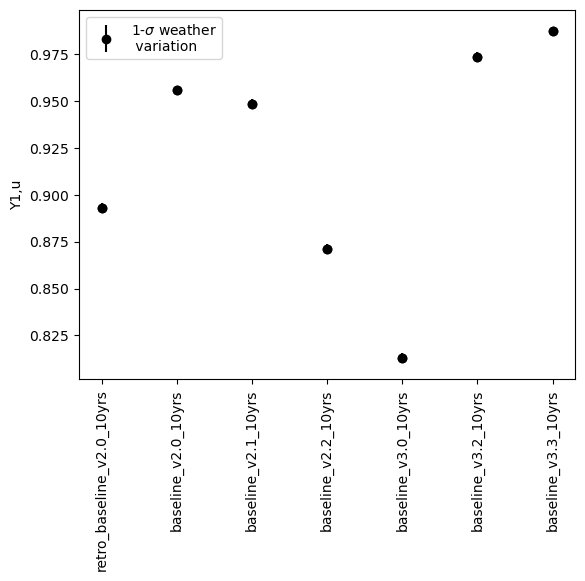

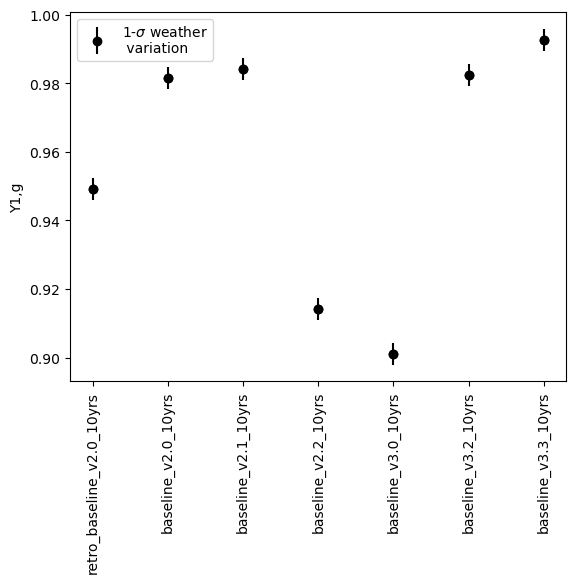

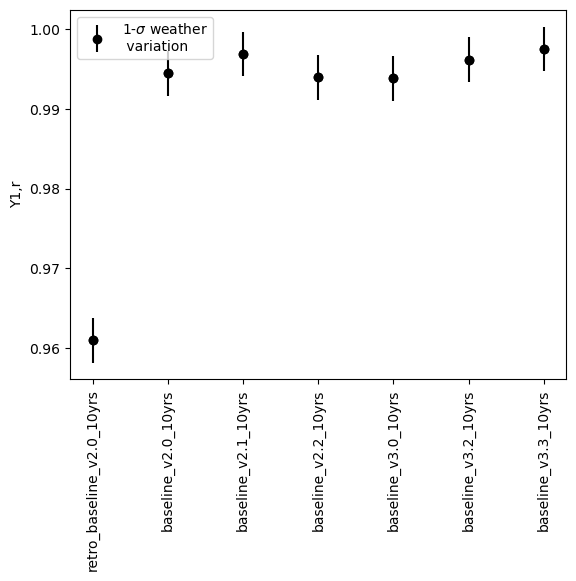

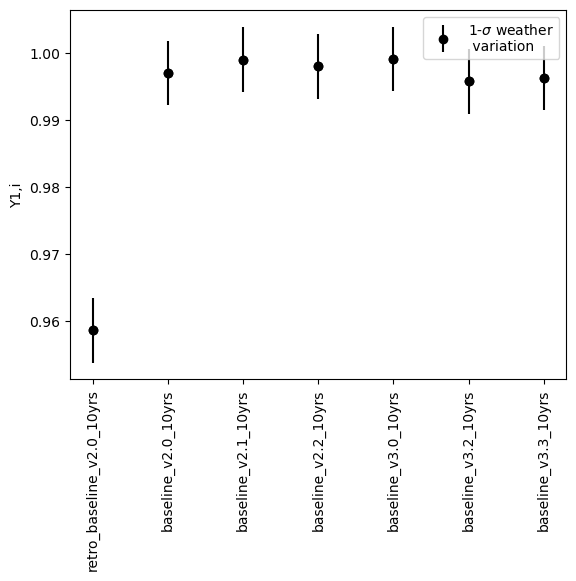

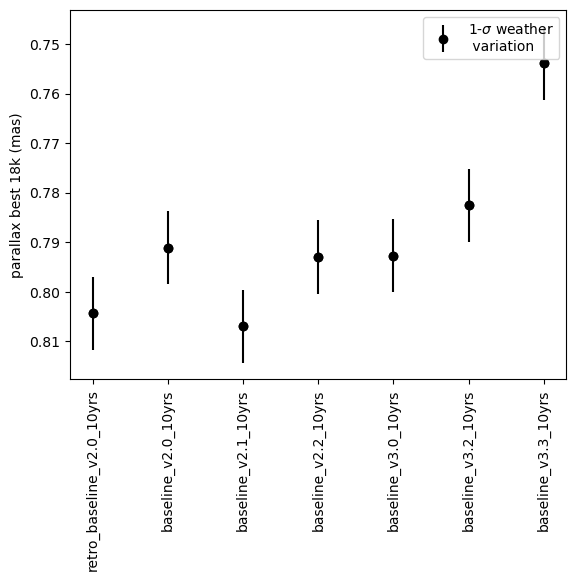

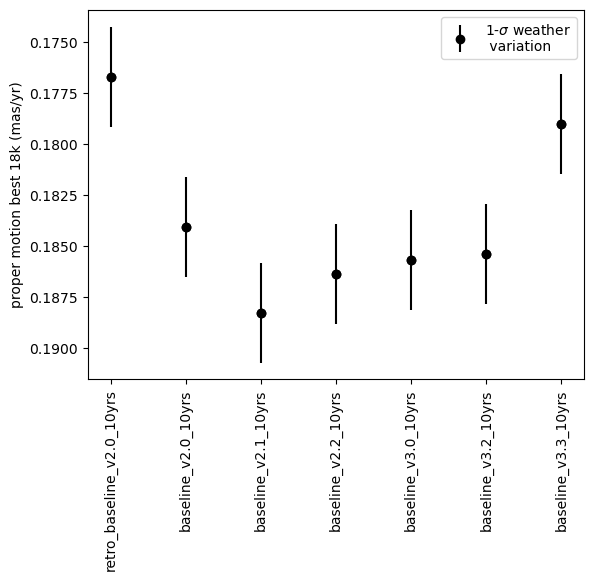

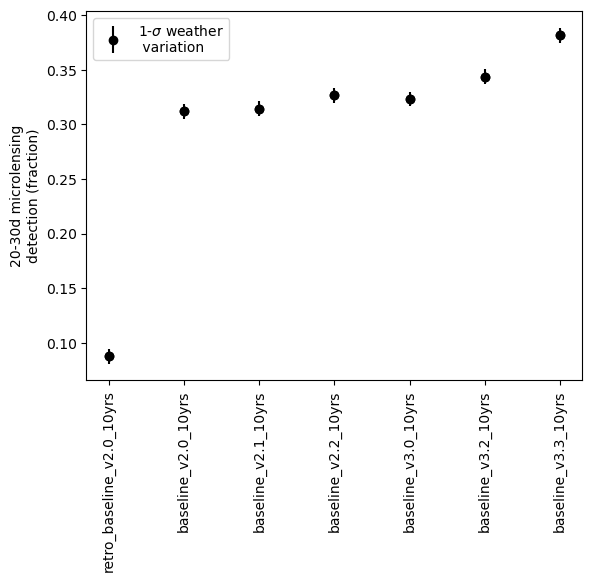

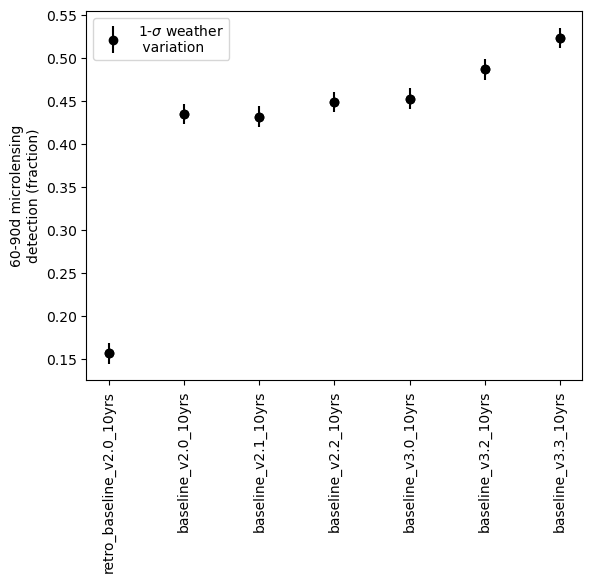

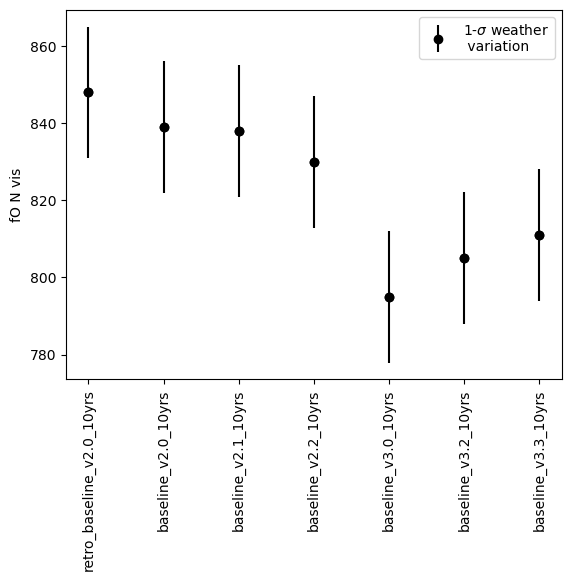

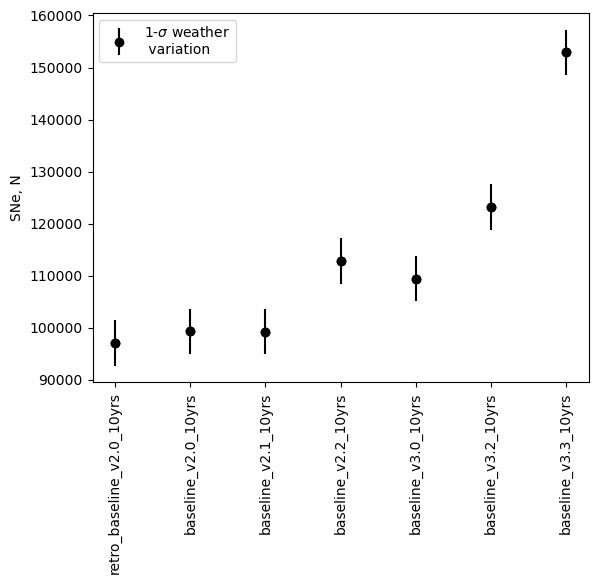

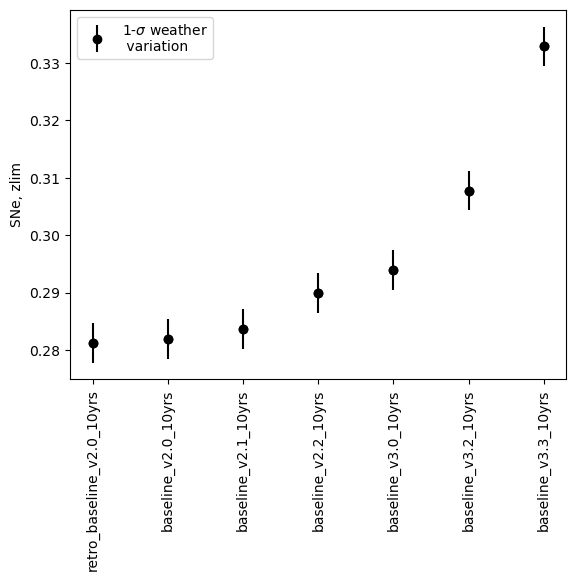

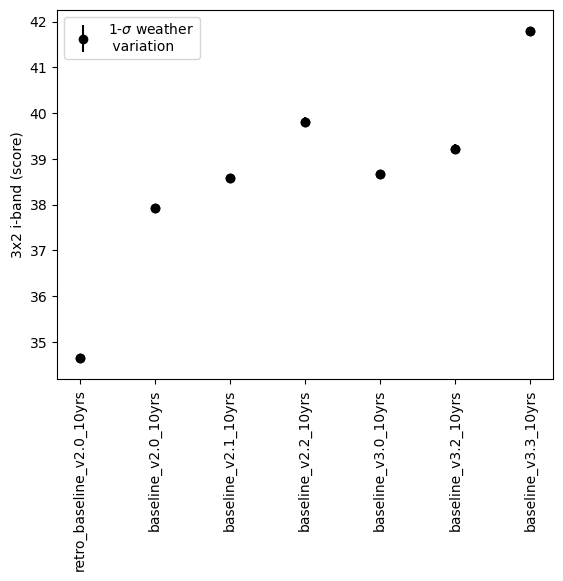

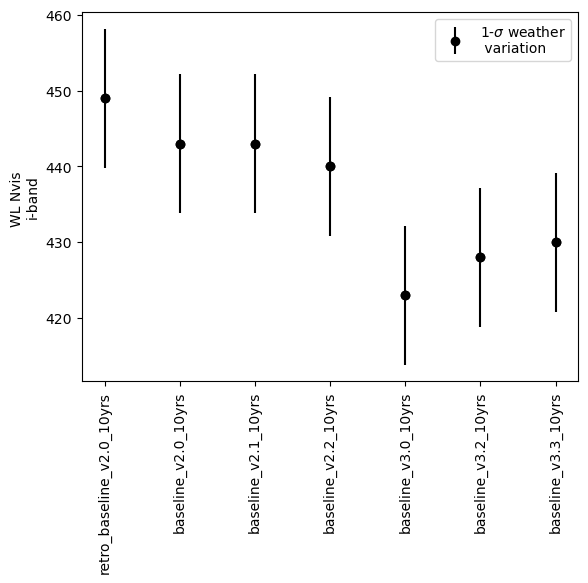

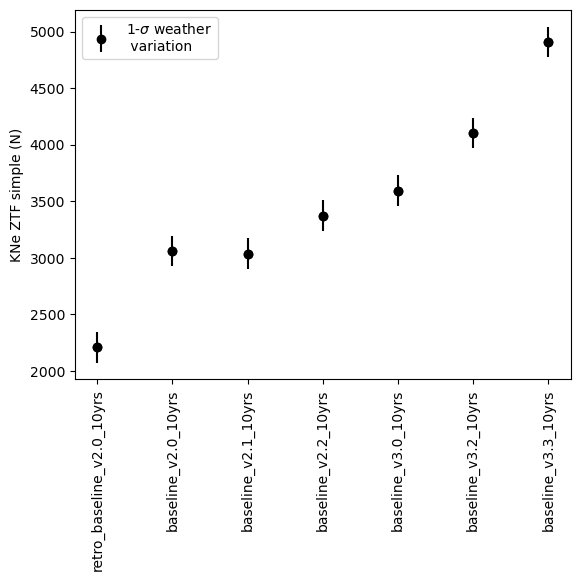

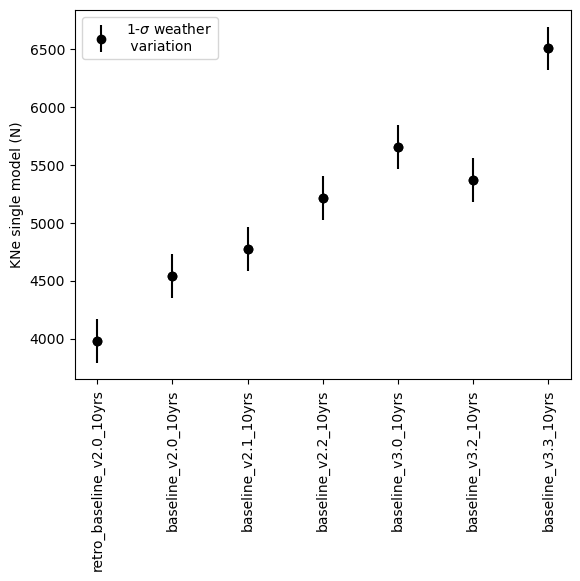

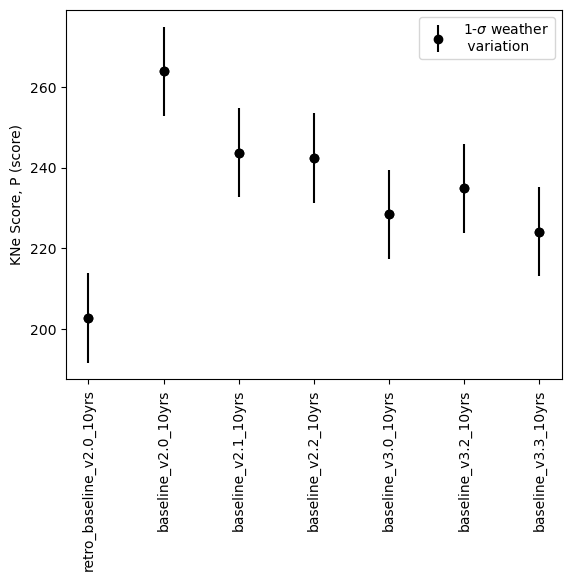

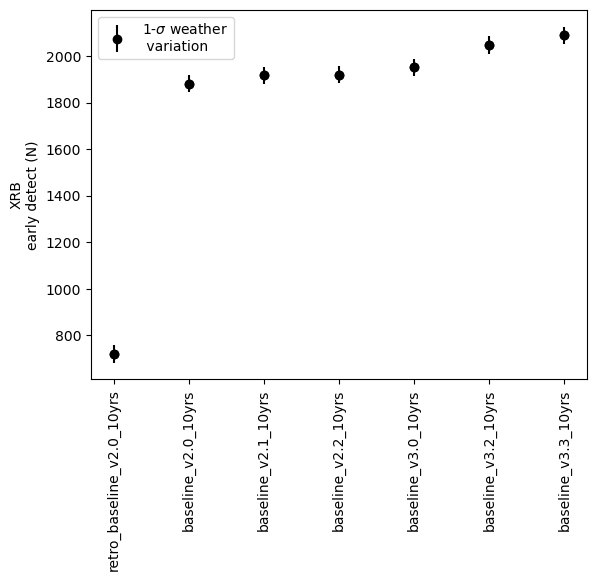

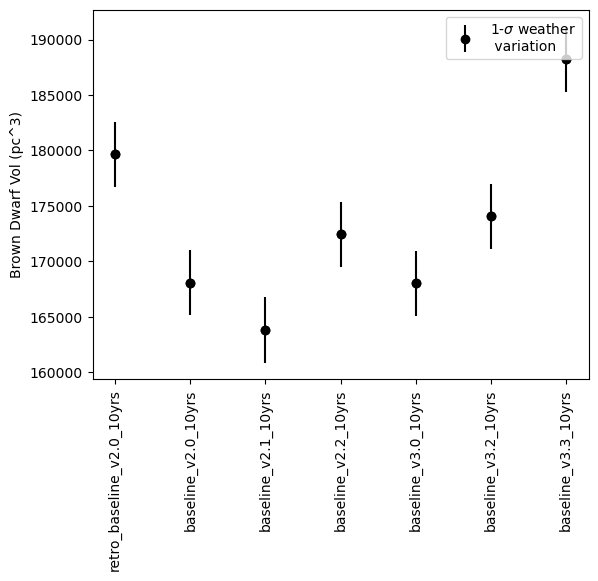

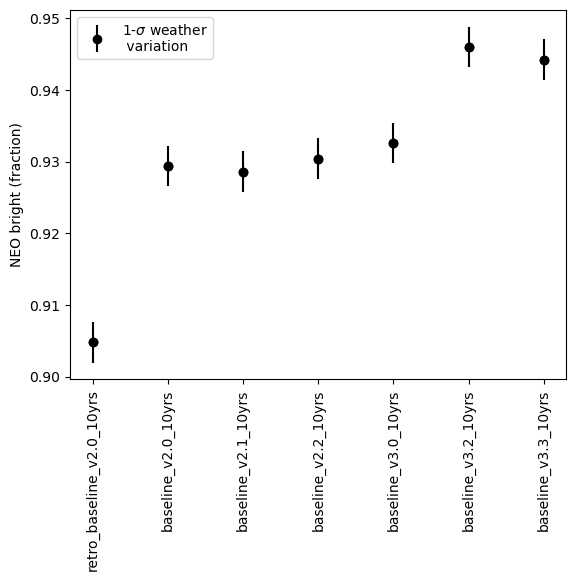

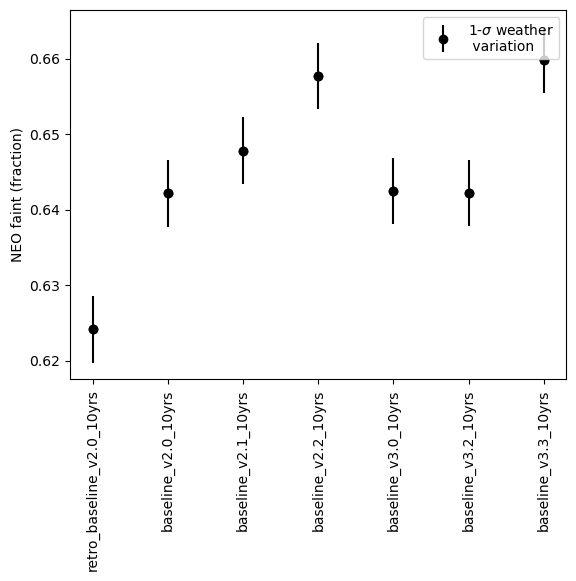

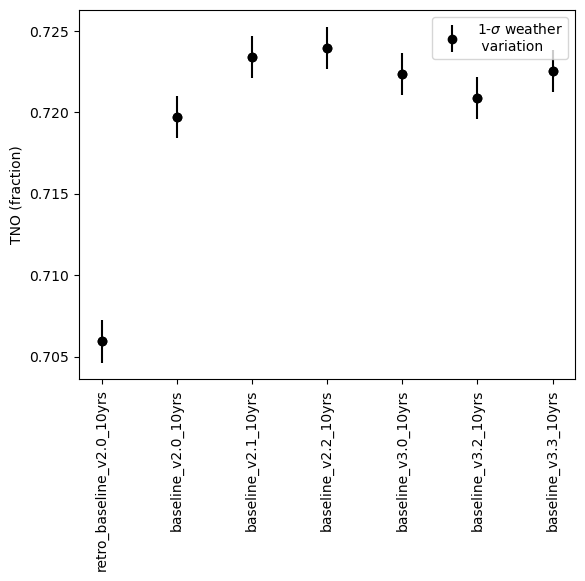

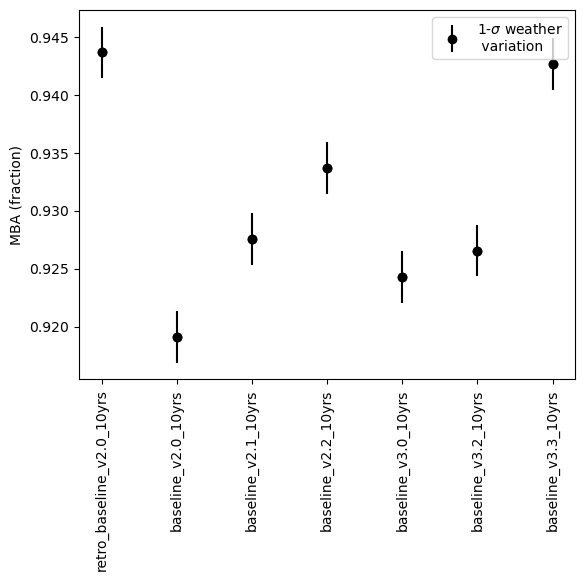

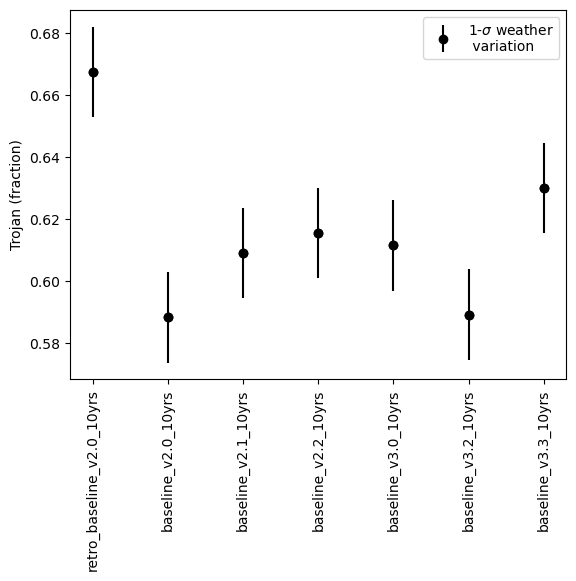

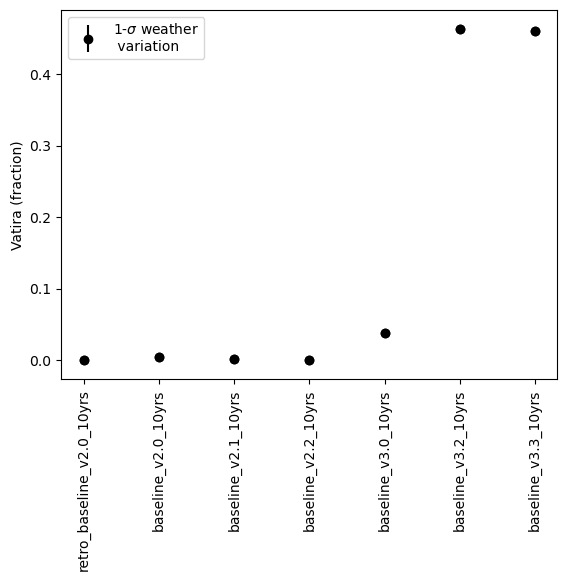

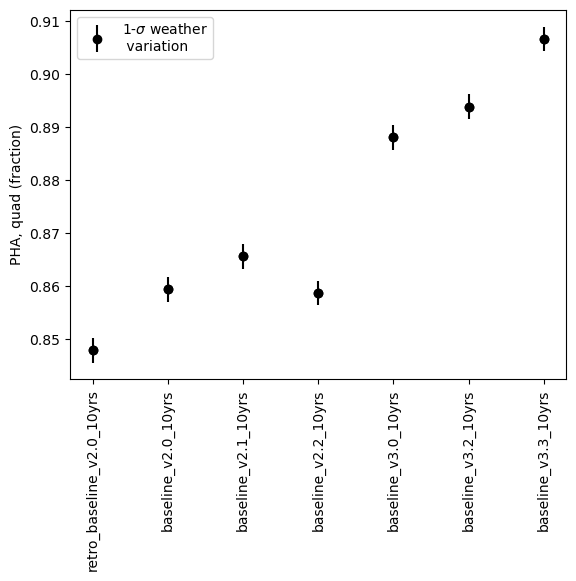

In [17]:
# Rough error bars from weather simulations
std_dict = {}
weather_runs = [run for run in data.index if 'weather' in run]
for col in data.columns:
    std_dict[col] = np.std(data.loc[weather_runs][col])

std_mag_dict = {}
for col in mag_data.columns:
    std_mag_dict[col] = np.std(mag_data.loc[weather_runs][col])
    
std_ddf_dict = {}
for col in ddf_data.columns:
    std_ddf_dict[col] = np.std(ddf_data.loc[weather_runs][col])
 

std_gaps_dict = {}
for col in gaps_data.columns:
    std_gaps_dict[col] = np.std(gaps_data.loc[weather_runs][col])


#col = data.columns[0]
for col in sub_data.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_data[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    if units[col] != '':
        label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])


/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_72787/1073381334.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col]/n, yerr=std_dict[col]/n, fmt='s', color='k',


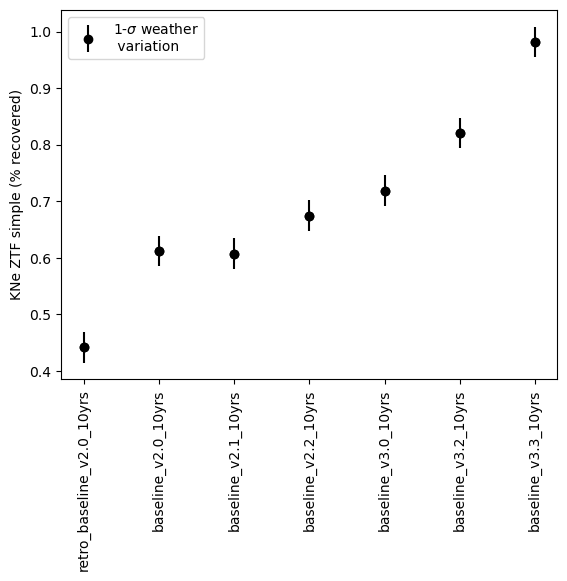

In [18]:
#col = data.columns[0]
n=500000/100
for col in ['KNe ZTF simple']:
    fig, ax = plt.subplots()
    ax.plot(sub_data[col]/n, 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col]/n, yerr=std_dict[col]/n, fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    if units[col] != '':
        label_add = ' (% recovered)'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])

/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_72787/1292493311.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',


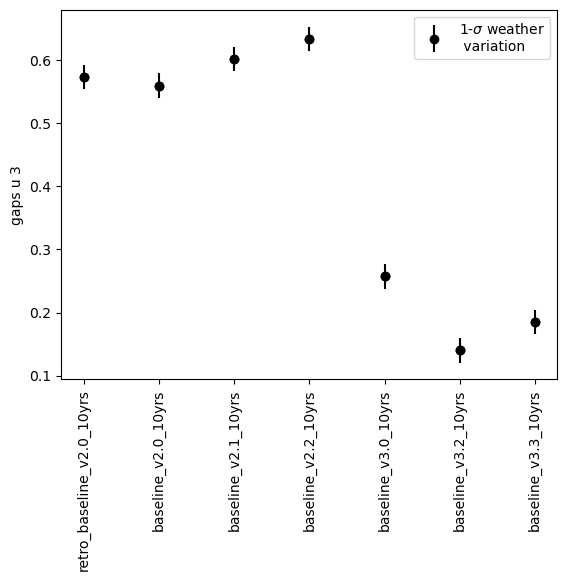

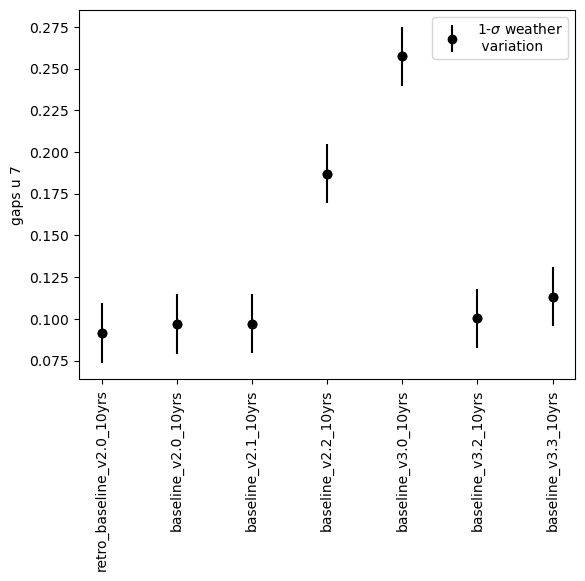

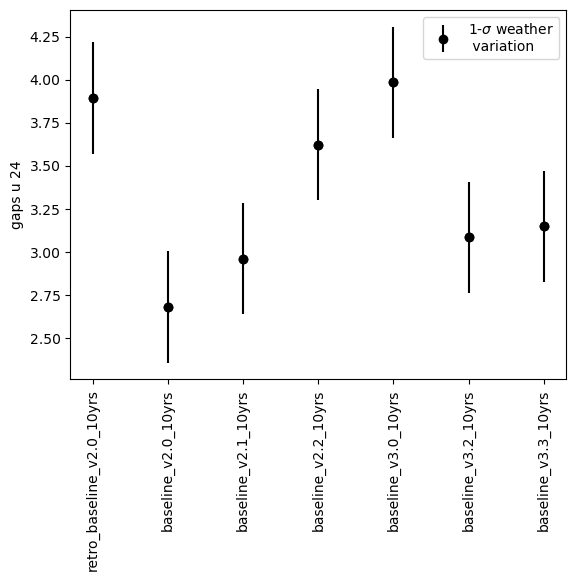

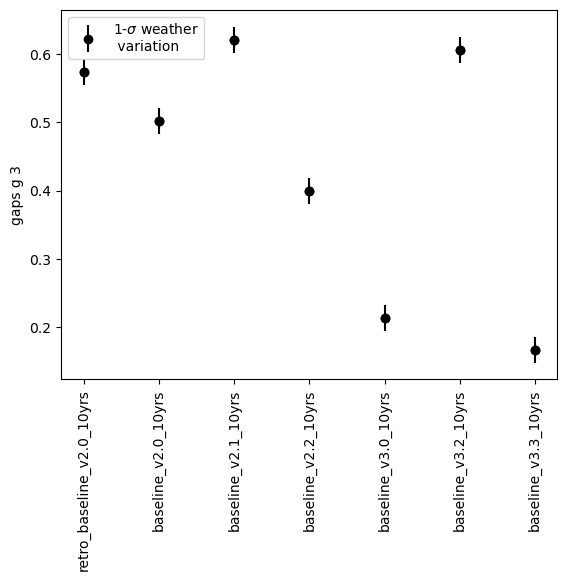

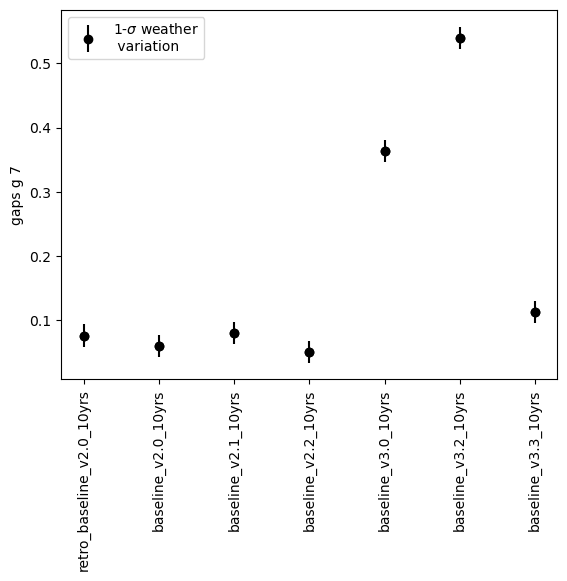

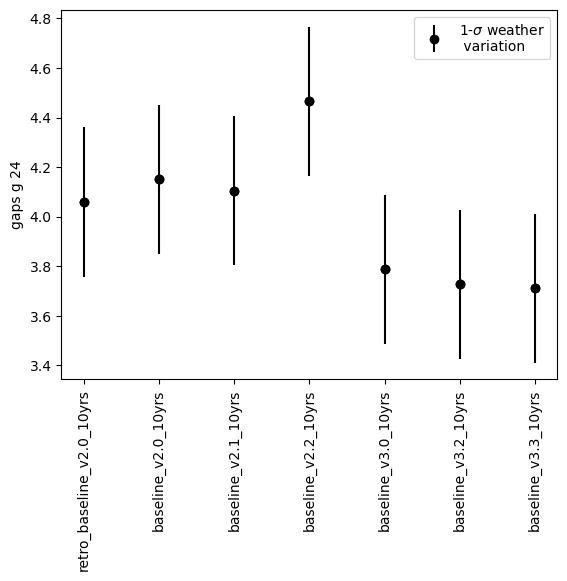

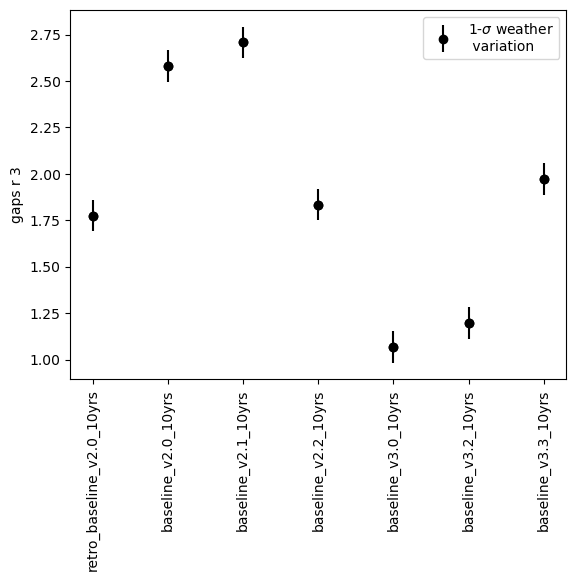

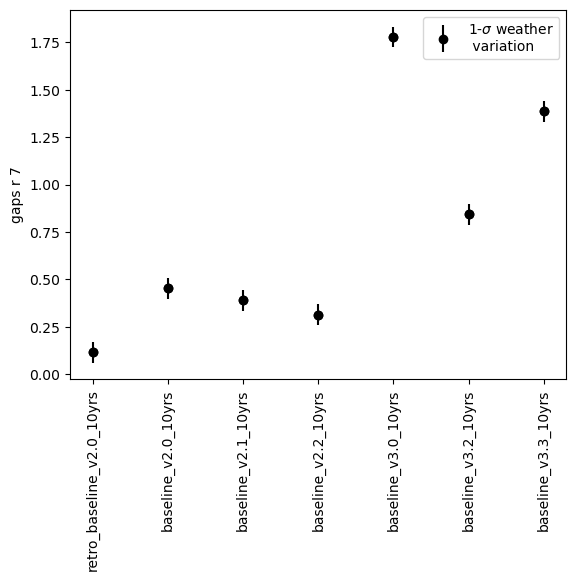

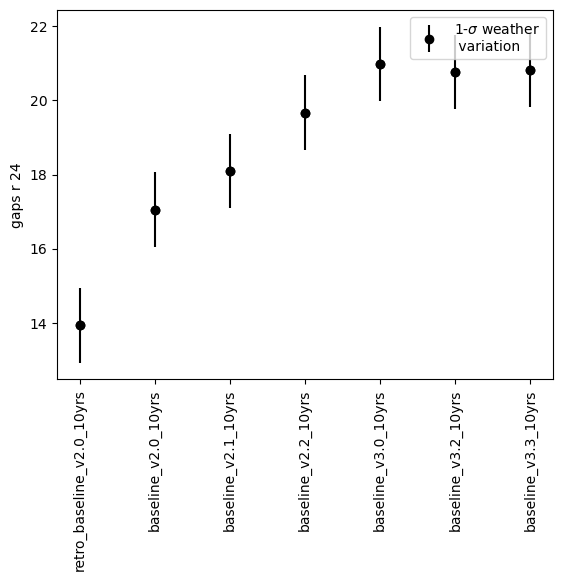

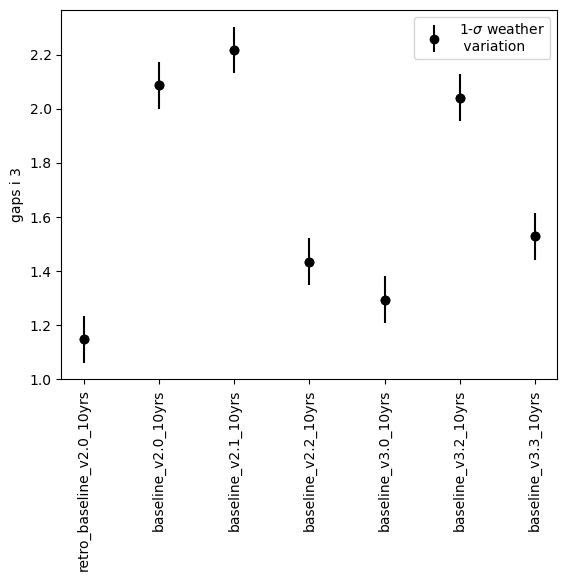

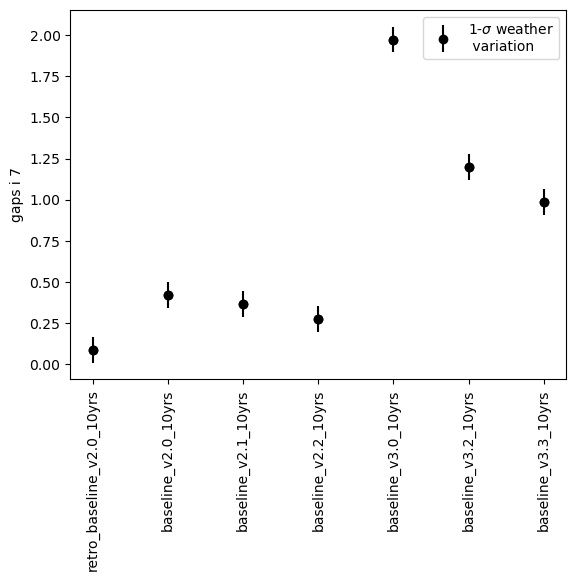

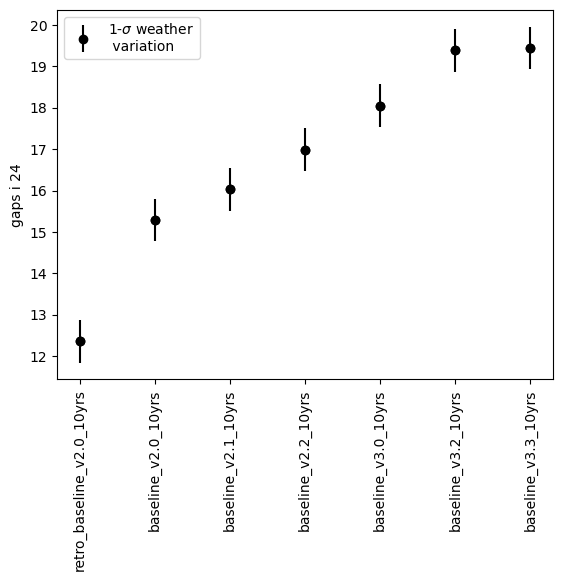

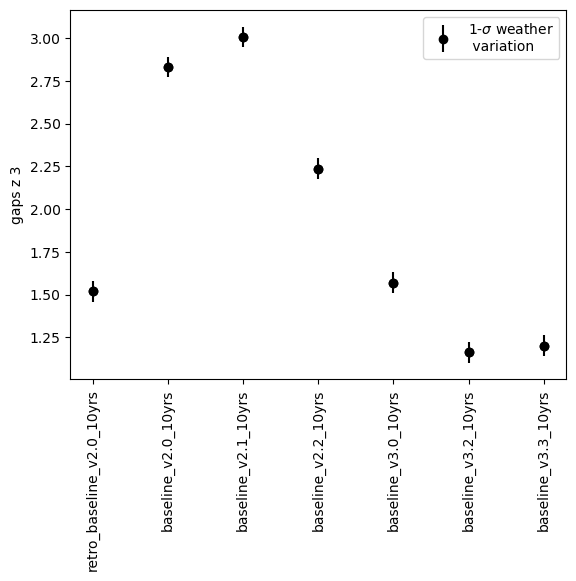

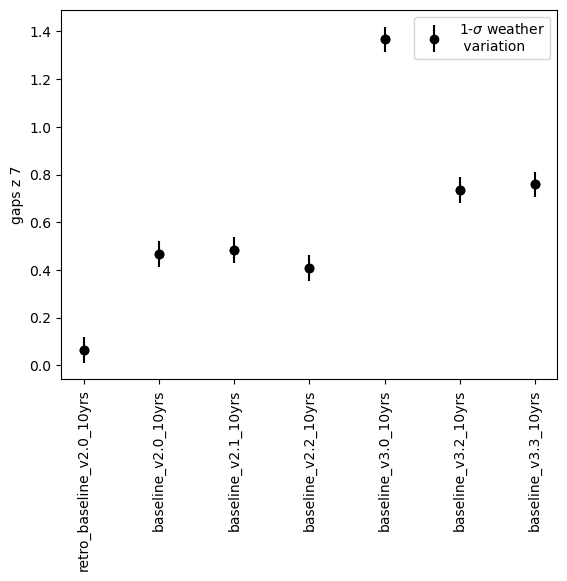

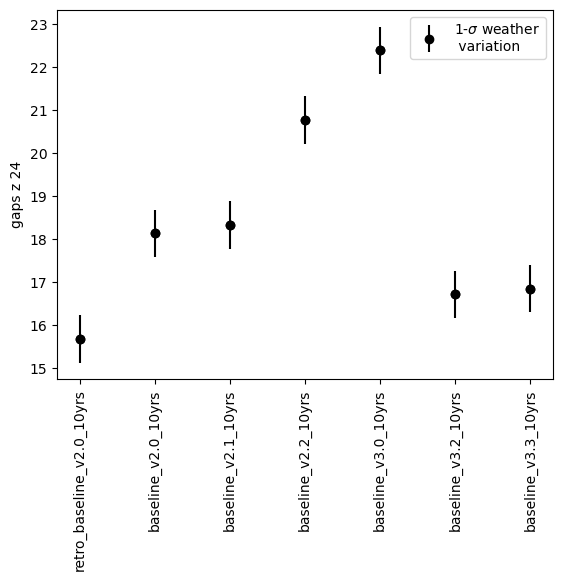

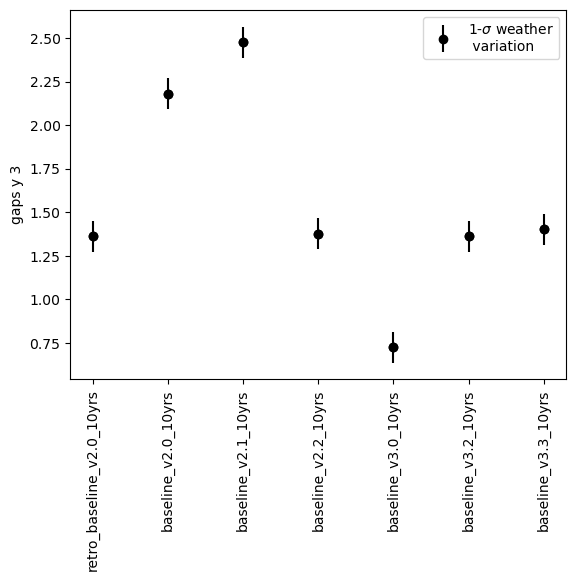

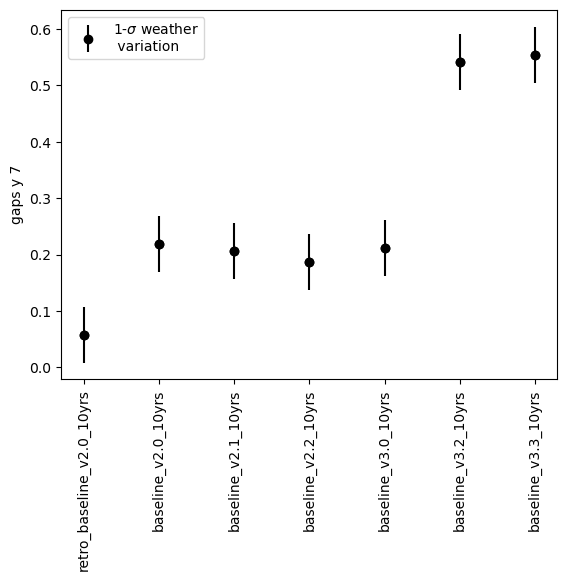

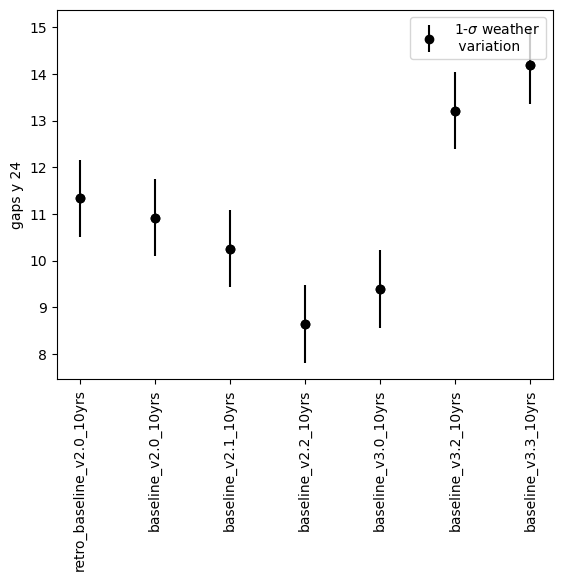

In [19]:
for col in sub_gaps.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_gaps[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    #if units[col] != '':
    #    label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])


/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_72787/1300353735.py:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_ddf_dict[col], fmt='s', color='k',


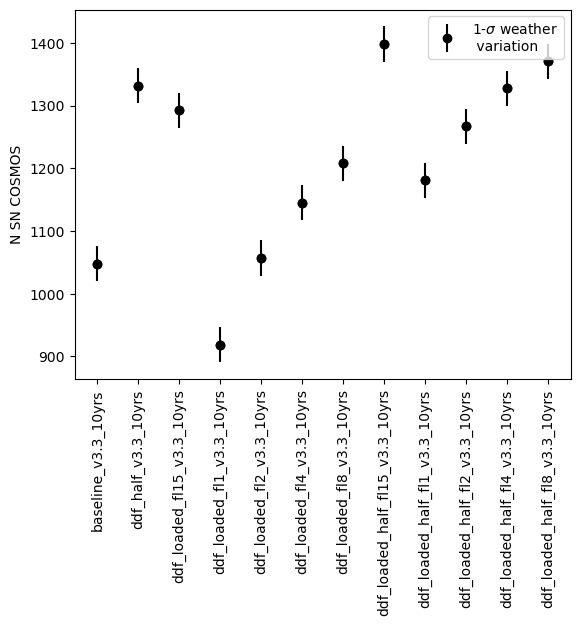

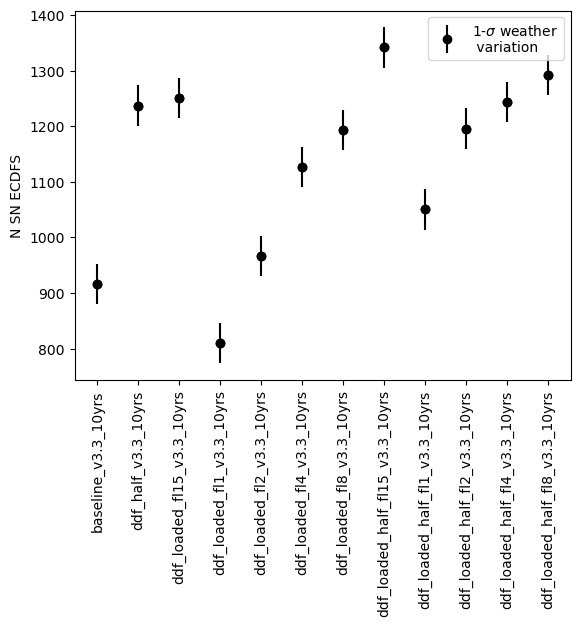

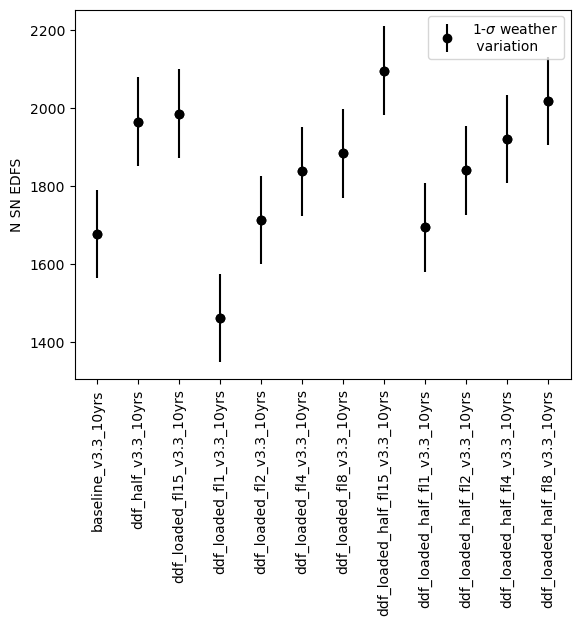

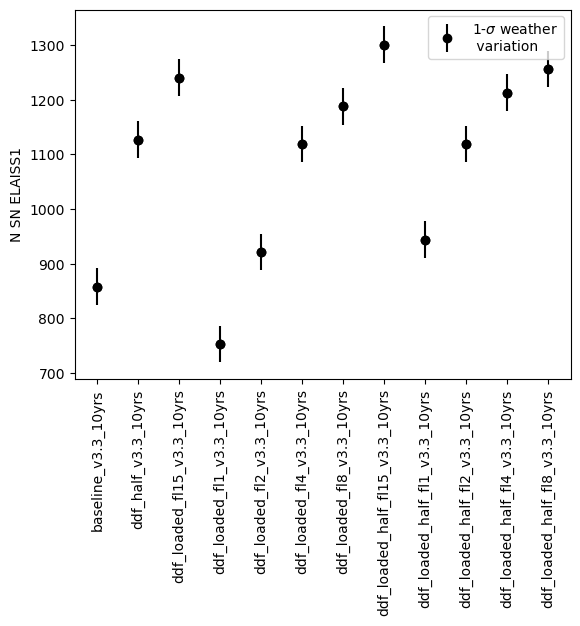

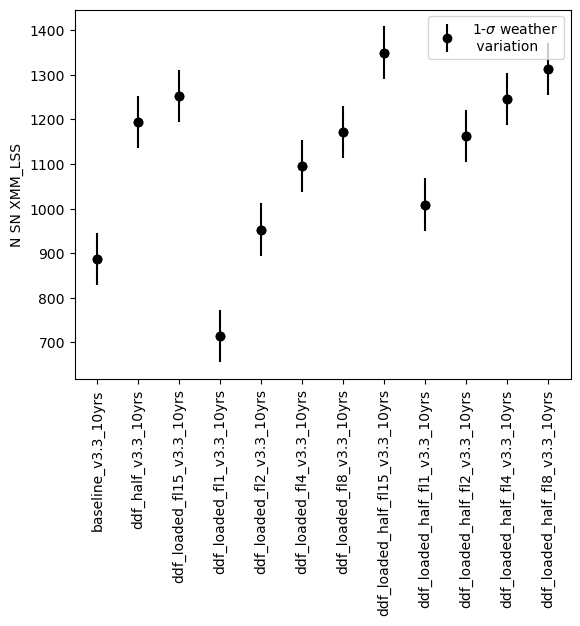

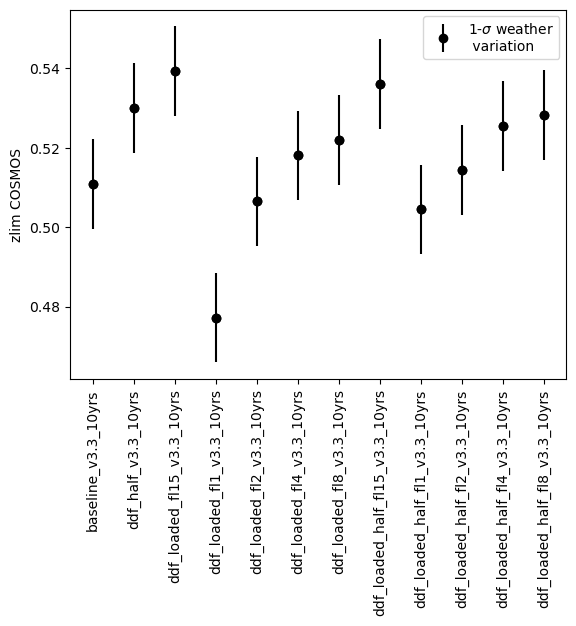

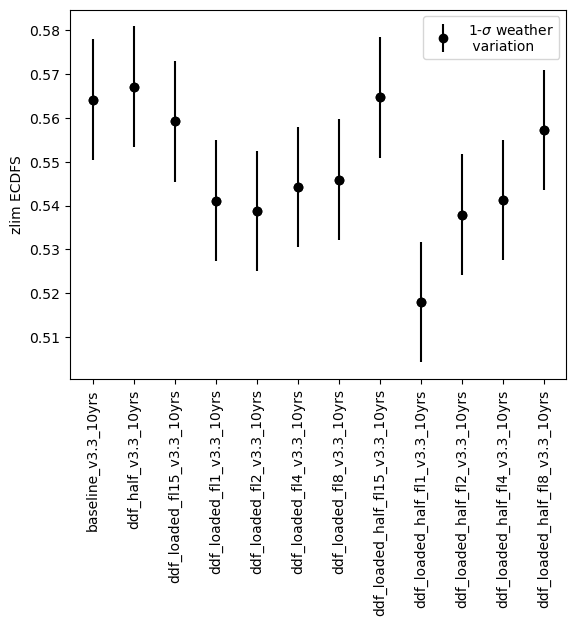

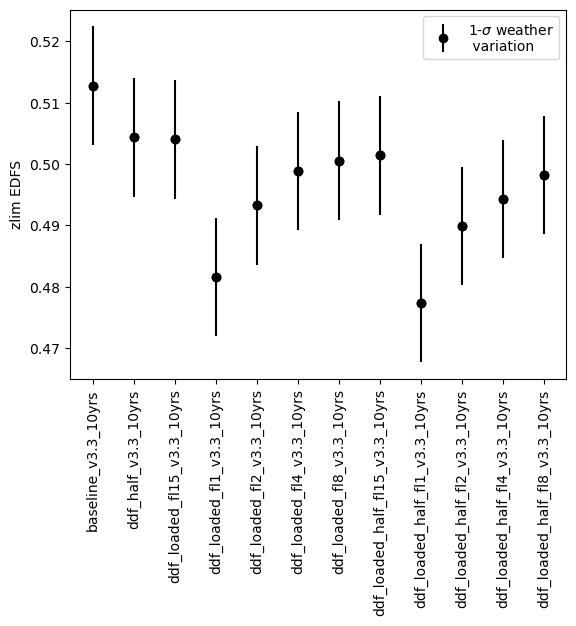

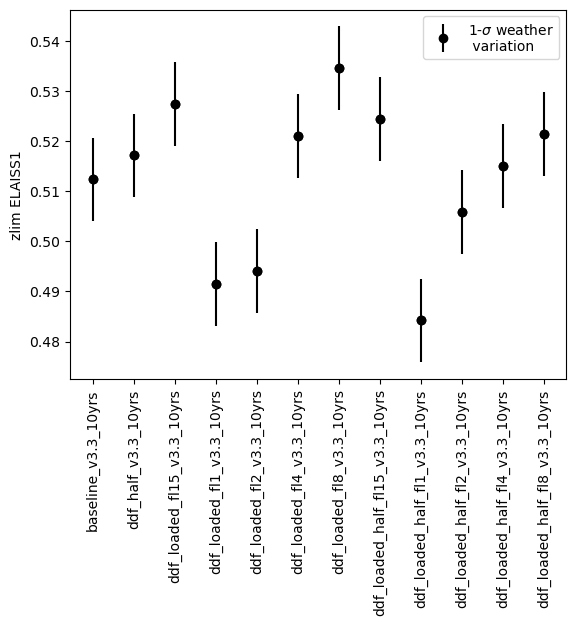

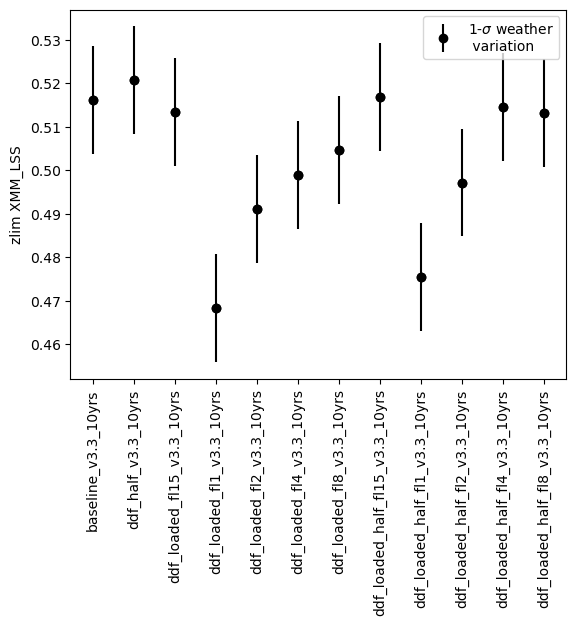

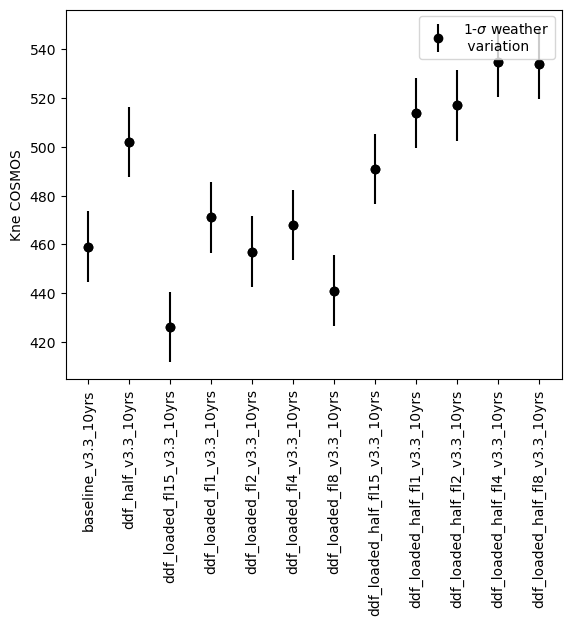

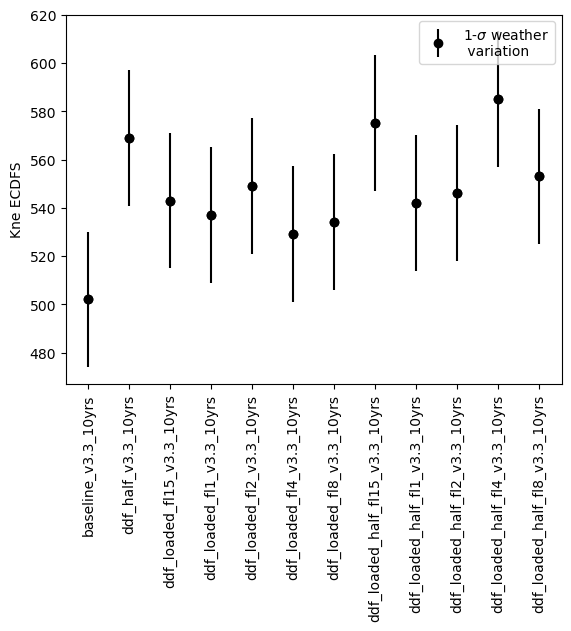

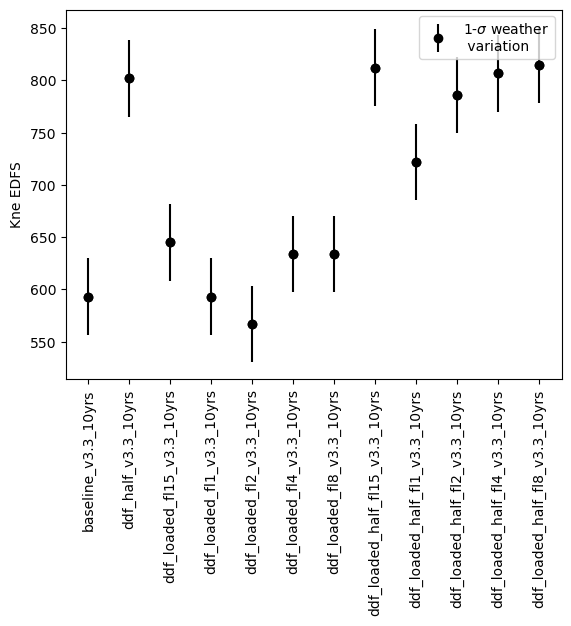

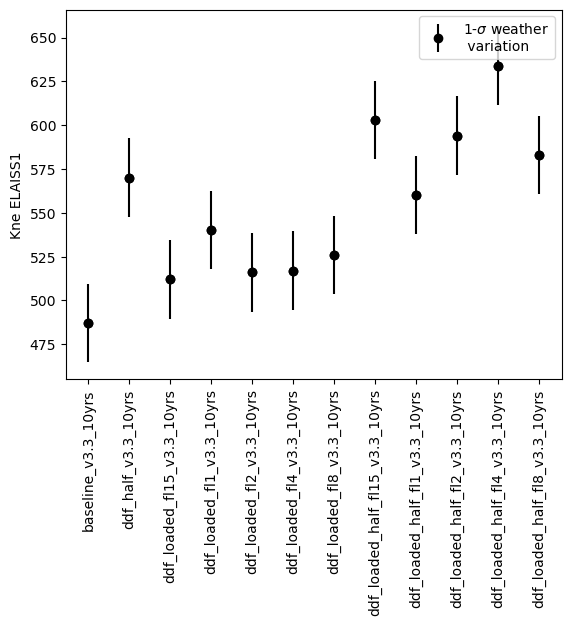

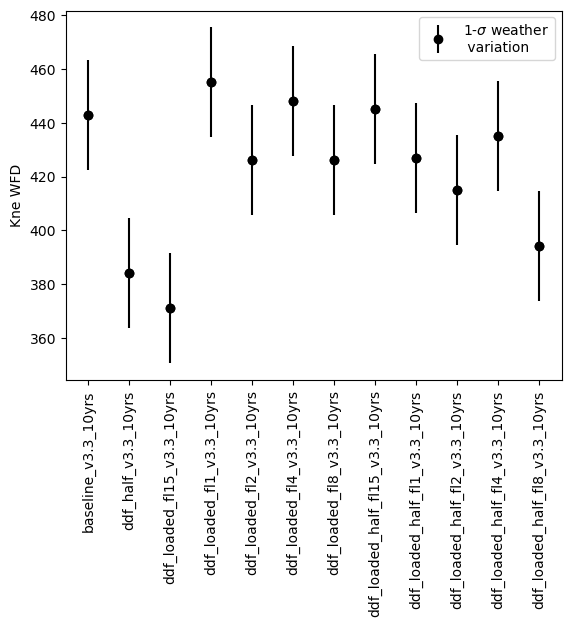

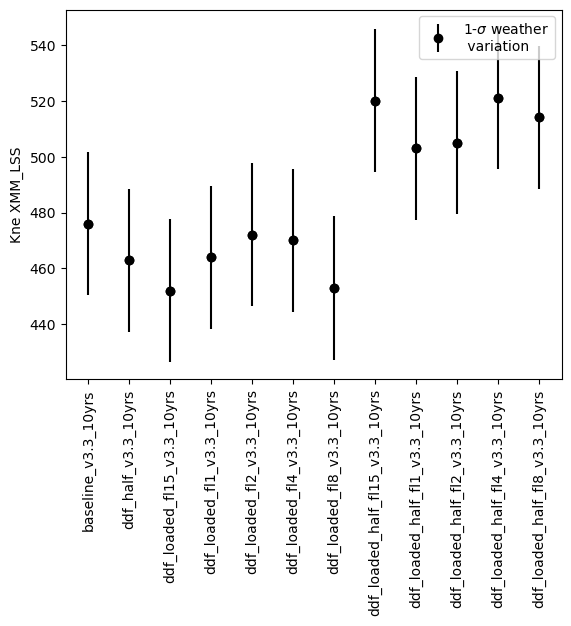

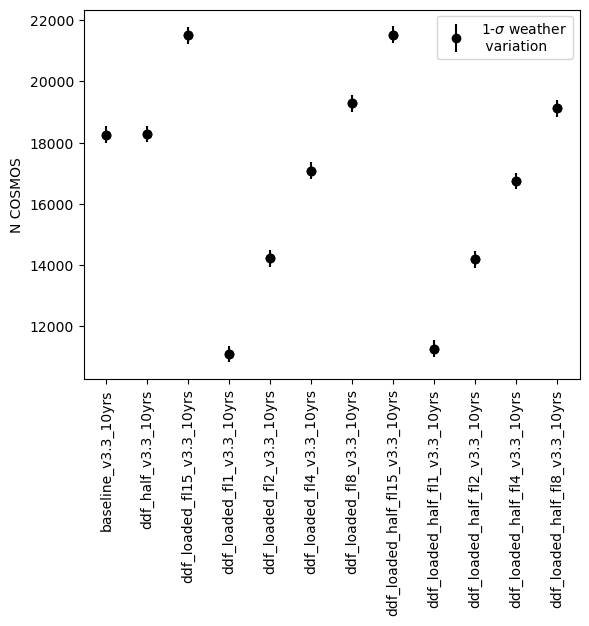

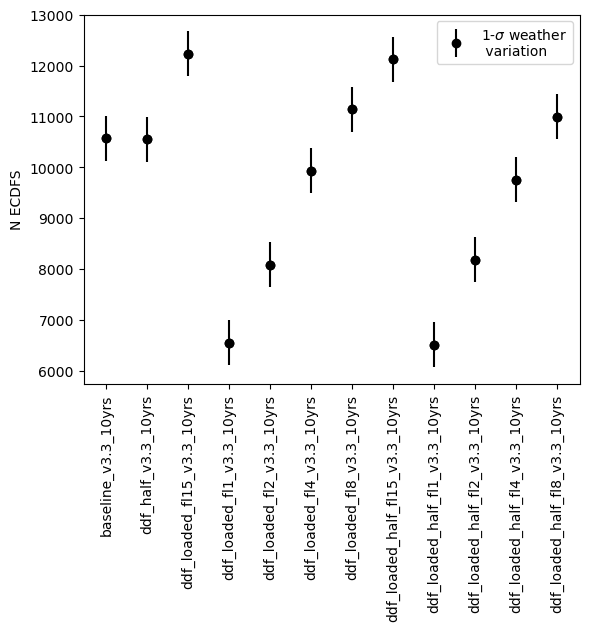

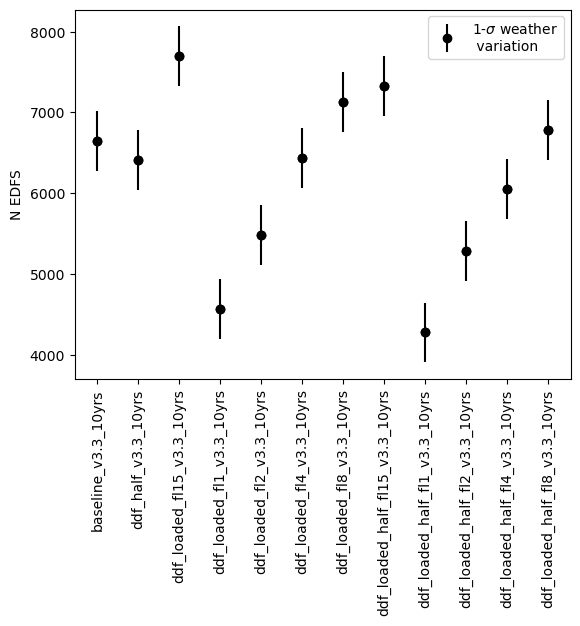

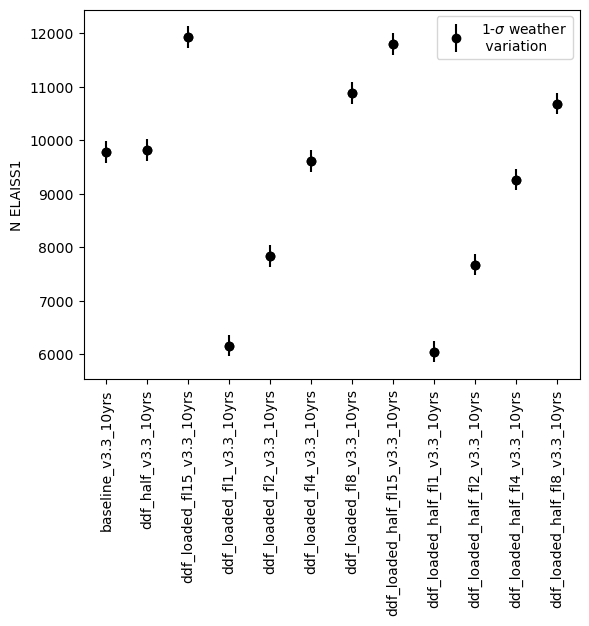

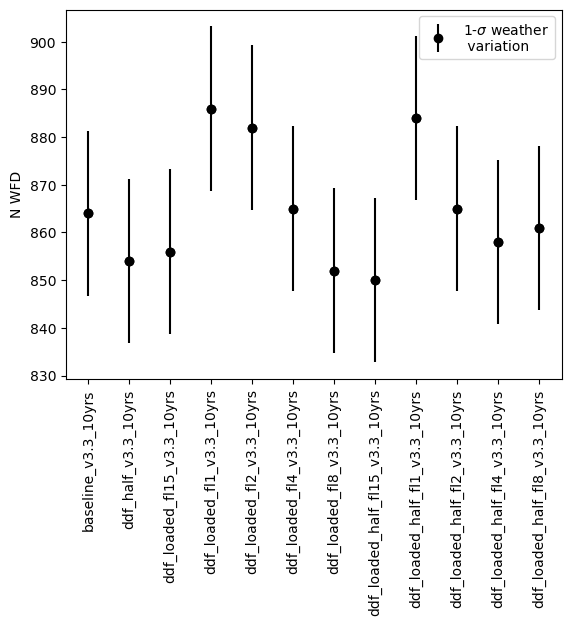

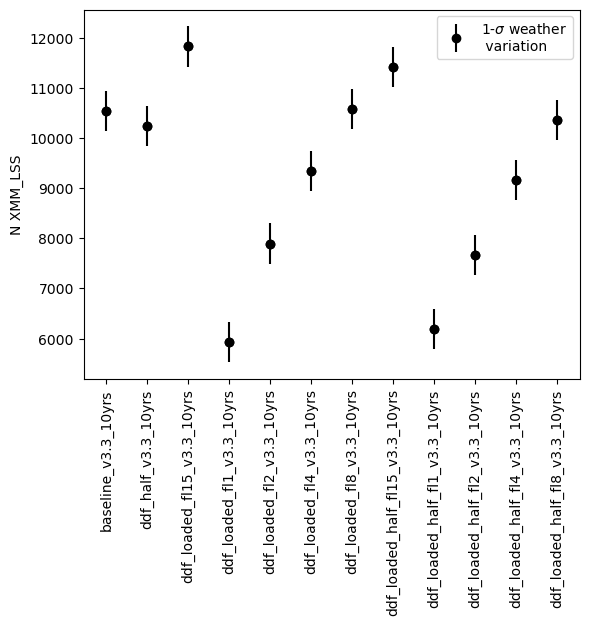

In [20]:
times = ['baseline_v3.3_10yrs'] + [run for run in data.index if 'ddf' in run and 'short' not in run]

sub_gaps = ddf_data.reindex(labels=times)



for col in sub_gaps.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_gaps[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_ddf_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    #if units[col] != '':
    #    label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])

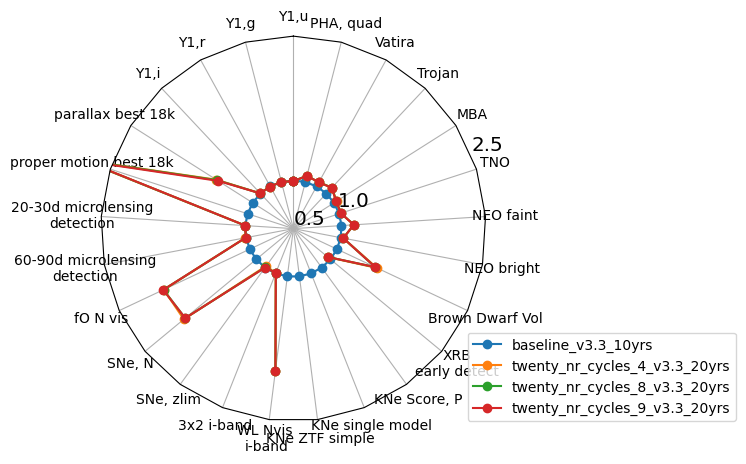

In [21]:
# Note the microlensing, XRB, and KNe metrics default to spreading objects over 10 years, 
# so those shouldn't change change.

runs = ['baseline_v3.3_10yrs'] + [run for run in data.index if 'twenty' in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.5, 1.0, 2.5], bbox_to_anchor=(1.65, 0))

In [22]:
data.loc[runs]['KNe single model']

baseline_v3.3_10yrs              6506.0
twenty_nr_cycles_4_v3.3_20yrs     134.0
twenty_nr_cycles_8_v3.3_20yrs     134.0
twenty_nr_cycles_9_v3.3_20yrs     134.0
Name: KNe single model, dtype: float64

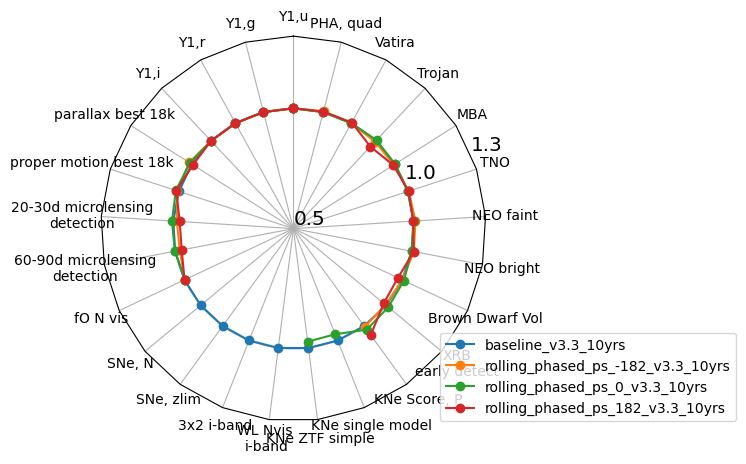

In [23]:
runs = ['baseline_v3.3_10yrs'] + [run for run in data.index if 'rolling_phase' in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.5, 1.0, 1.3], bbox_to_anchor=(1.65, 0))

In [24]:
data.loc[runs]['WL Nvis \ni-band']

baseline_v3.3_10yrs                  430.0
rolling_phased_ps_-182_v3.3_10yrs      NaN
rolling_phased_ps_0_v3.3_10yrs         NaN
rolling_phased_ps_182_v3.3_10yrs       NaN
Name: WL Nvis \ni-band, dtype: float64

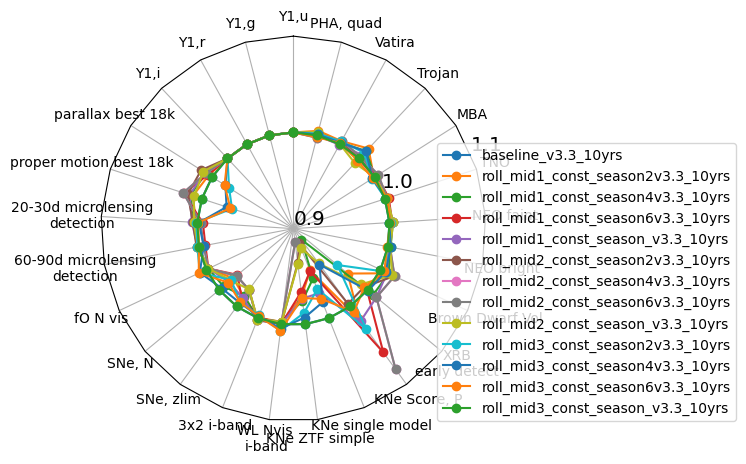

In [25]:
runs = ['baseline_v3.3_10yrs'] + [run for run in data.index if 'roll_mid' in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

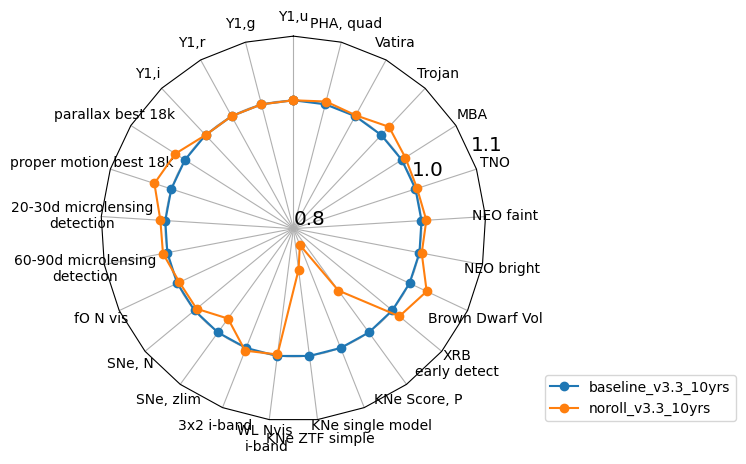

In [26]:
runs = ['baseline_v3.3_10yrs'] + [run for run in data.index if 'noroll' in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

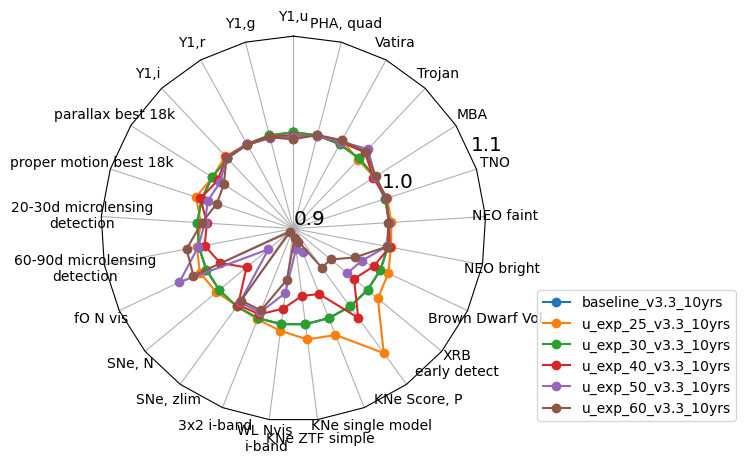

In [27]:
runs = ['baseline_v3.3_10yrs'] + [run for run in data.index if 'u_exp' in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

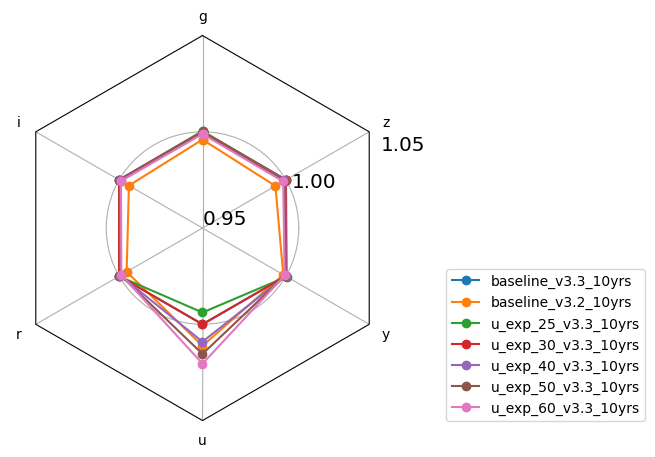

In [28]:
runs = ['baseline_v3.3_10yrs','baseline_v3.2_10yrs'] + [run for run in data.index if 'u_exp' in run]

ndata = norm_df(mag_data, runs, cols=mag_data.columns.values.tolist(),
                 mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.95, 1.0, 1.05], bbox_to_anchor=(1.65, 0))

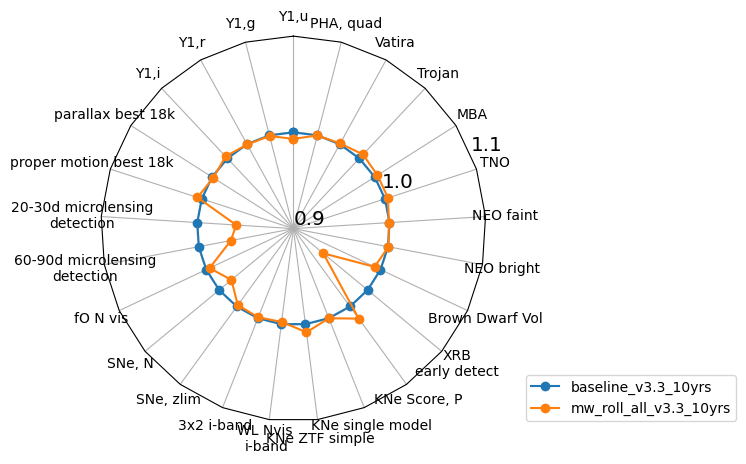

In [29]:
runs = ['baseline_v3.3_10yrs'] + [run for run in data.index if 'mw' in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

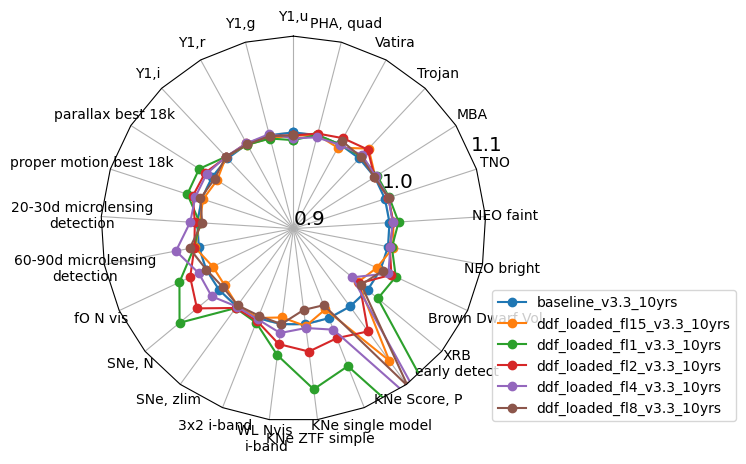

In [30]:
runs = ['baseline_v3.3_10yrs'] + [run for run in data.index if 'ddf' in run and 'half' not in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

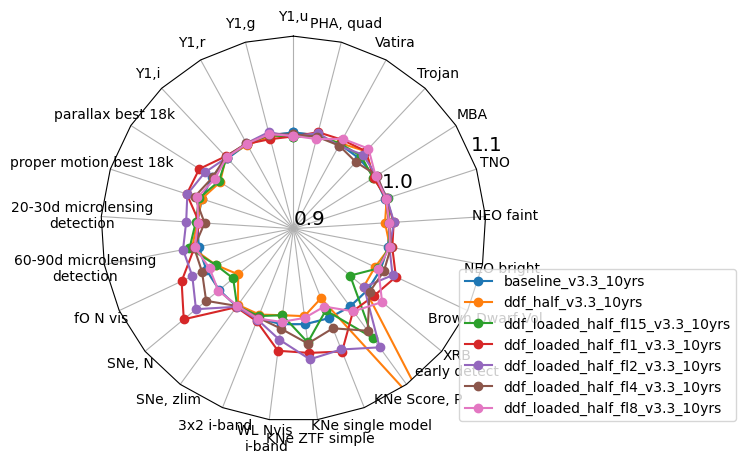

In [31]:
runs = ['baseline_v3.3_10yrs'] + [run for run in data.index if 'ddf' in run and 'half' in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

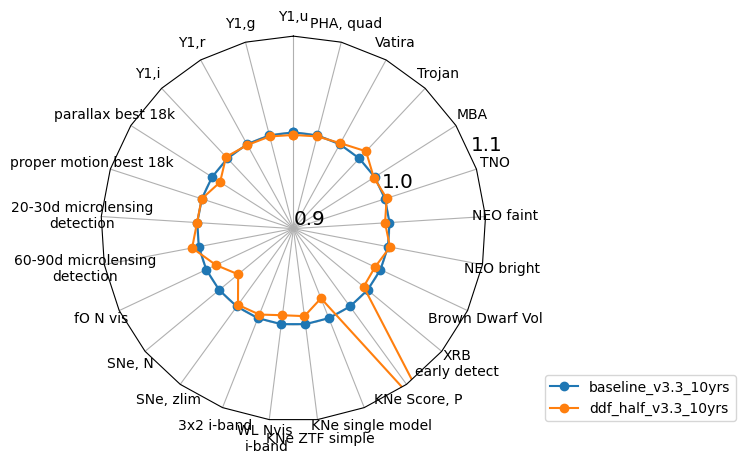

In [32]:
runs = ['baseline_v3.3_10yrs', 'ddf_half_v3.3_10yrs'] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

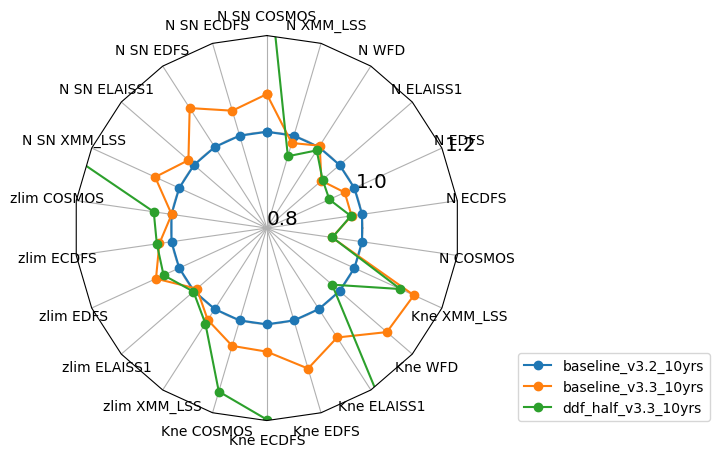

In [33]:
runs = ['baseline_v3.2_10yrs','baseline_v3.3_10yrs', 'ddf_half_v3.3_10yrs'] 

ndata = norm_df(ddf_data, runs, cols=ddf_data.columns.values.tolist(),
                invert_cols=None, mag_cols = mag_cols, norm_run='baseline_v3.2_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.2], bbox_to_anchor=(1.65, 0))

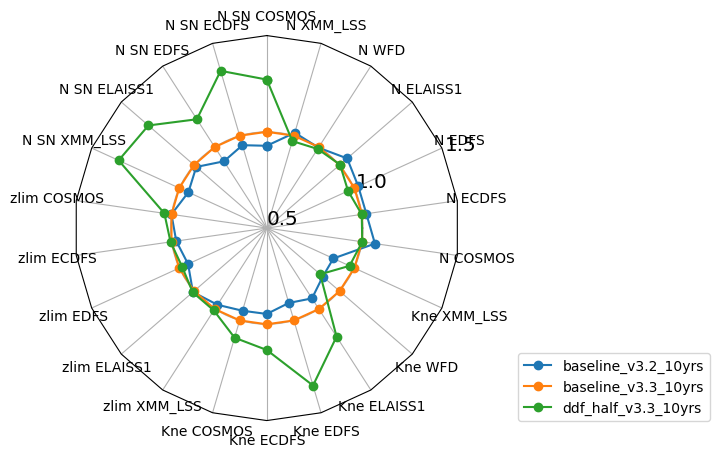

In [34]:
ndata = norm_df(ddf_data, runs, cols=ddf_data.columns.values.tolist(),
                invert_cols=None, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.5, 1.0, 1.5], bbox_to_anchor=(1.65, 0))

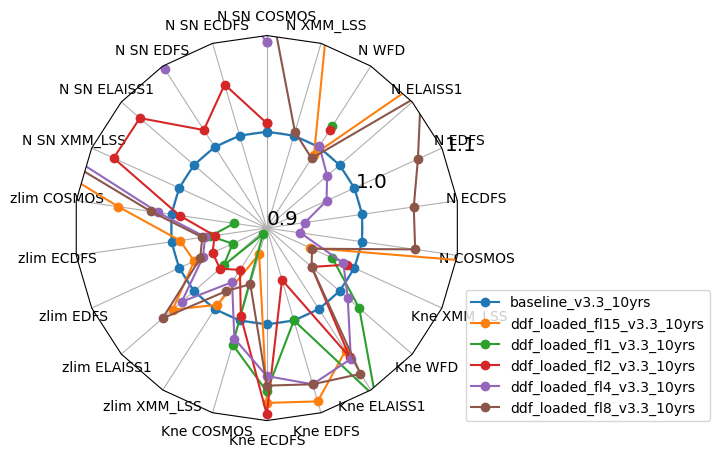

In [35]:
runs = ['baseline_v3.3_10yrs'] + [run for run in data.index if 'ddf' in run and 'half' not in run]


ndata = norm_df(ddf_data, runs, cols=ddf_data.columns.values.tolist(),
                invert_cols=None, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

In [36]:
ndata

N SN COSMOS  N SN ECDFS  N SN EDFS  N SN ELAISS1  \
baseline_v3.3_10yrs            1.000000    1.000000   1.000000      1.000000   
ddf_loaded_fl15_v3.3_10yrs     1.233581    1.366544   1.184222      1.446115   
ddf_loaded_fl1_v3.3_10yrs      0.876722    0.884294   0.871173      0.877466   
ddf_loaded_fl2_v3.3_10yrs      1.008953    1.055404   1.021026      1.074489   
ddf_loaded_fl4_v3.3_10yrs      1.093244    1.229841   1.095889      1.304879   
ddf_loaded_fl8_v3.3_10yrs      1.152797    1.303223   1.123134      1.384754   

                            N SN XMM_LSS  zlim COSMOS  zlim ECDFS  zlim EDFS  \
baseline_v3.3_10yrs             1.000000     1.000000    1.000000   1.000000   
ddf_loaded_fl15_v3.3_10yrs      1.411999     1.055783    0.991144   0.982866   
ddf_loaded_fl1_v3.3_10yrs       0.805145     0.934243    0.959159   0.939079   
ddf_loaded_fl2_v3.3_10yrs       1.074935     0.991543    0.954882   0.961873   
ddf_loaded_fl4_v3.3_10yrs       1.236102     1.014247    0.964710   0.972901   
ddf_loaded_fl8_v3.3_10yrs       1.321653     1.021825    0.967657   0.976137   

                            zlim ELAISS1  zlim XMM_LSS  ...  Kne EDFS  \
baseline_v3.3_10yrs             1.000000      1.000000  ...  1.000000   
ddf_loaded_fl15_v3.3_10yrs      1.029384      0.994822  ...  1.087690   
ddf_loaded_fl1_v3.3_10yrs       0.959166      0.907295  ...  1.000000   
ddf_loaded_fl2_v3.3_10yrs       0.964387      0.951662  ...  0.956155   
ddf_loaded_fl4_v3.3_10yrs       1.017000      0.966765  ...  1.069140   
ddf_loaded_fl8_v3.3_10yrs       1.043299      0.977785  ...  1.069140   

                            Kne ELAISS1   Kne WFD  Kne XMM_LSS  N COSMOS  \
baseline_v3.3_10yrs            1.000000  1.000000     1.000000  1.000000   
ddf_loaded_fl15_v3.3_10yrs     1.051335  0.837472     0.949580  1.177732   
ddf_loaded_fl1_v3.3_10yrs      1.108830  1.027088     0.974790  0.607414   
ddf_loaded_fl2_v3.3_10yrs      1.059548  0.961625     0.991597  0.778520   
ddf_loaded_fl4_v3.3_10yrs      1.061602  1.011287     0.987395  0.935363   
ddf_loaded_fl8_v3.3_10yrs      1.080082  0.961625     0.951681  1.055740   

                             N ECDFS    N EDFS  N ELAISS1     N WFD  N XMM_LSS  
baseline_v3.3_10yrs         1.000000  1.000000   1.000000  1.000000   1.000000  
ddf_loaded_fl15_v3.3_10yrs  1.157158  1.156969   1.218871  0.990741   1.122155  
ddf_loaded_fl1_v3.3_10yrs   0.619690  0.685762   0.630035  1.025463   0.562026  
ddf_loaded_fl2_v3.3_10yrs   0.764973  0.823936   0.801574  1.020833   0.748957  
ddf_loaded_fl4_v3.3_10yrs   0.940013  0.968275   0.982928  1.001157   0.886571  
ddf_loaded_fl8_v3.3_10yrs   1.054262  1.072621   1.111736  0.986111   1.003983  

[6 rows x 22 columns]

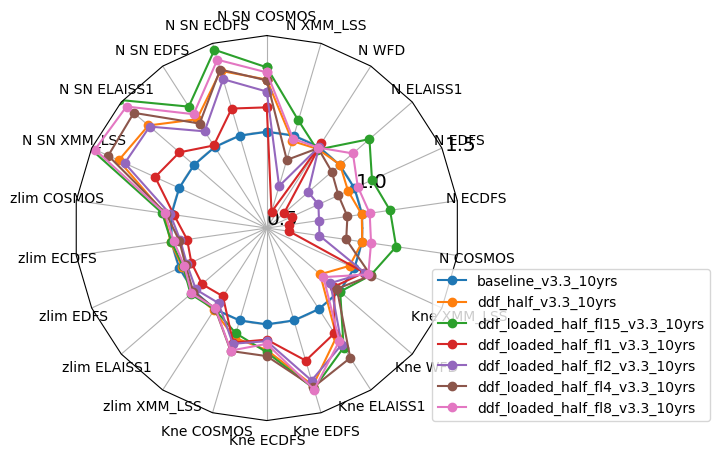

In [37]:
runs = ['baseline_v3.3_10yrs'] + [run for run in data.index if 'ddf' in run and 'half' in run]


ndata = norm_df(ddf_data, runs, cols=ddf_data.columns.values.tolist(),
                invert_cols=None, mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.5, 1.0, 1.5], bbox_to_anchor=(1.65, 0))

In [38]:

sub_mag




g          i          r          u  \
retro_baseline_v2.0_10yrs  26.835006  26.308518  26.850968  25.707301   
baseline_v2.0_10yrs        26.733479  26.218659  26.755971  25.818916   
baseline_v2.1_10yrs        26.736248  26.252054  26.781543  25.751969   
baseline_v2.2_10yrs        26.753646  26.290929  26.835430  25.724699   
baseline_v3.0_10yrs        26.688123  26.264600  26.818287  25.668262   
baseline_v3.2_10yrs        26.678103  26.295888  26.807880  25.622696   
baseline_v3.3_10yrs        26.786124  26.451047  26.929058  25.338704   

                                   y          z  
retro_baseline_v2.0_10yrs  24.842363  25.606168  
baseline_v2.0_10yrs        24.762720  25.510379  
baseline_v2.1_10yrs        24.728145  25.486640  
baseline_v2.2_10yrs        24.782743  25.581317  
baseline_v3.0_10yrs        24.756955  25.524781  
baseline_v3.2_10yrs        24.766647  25.586860  
baseline_v3.3_10yrs        24.805181  25.748060

/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_72787/2717096801.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_mag[col].values.size), sub_mag[col], yerr=std_mag_dict[col], fmt='s', color='k',


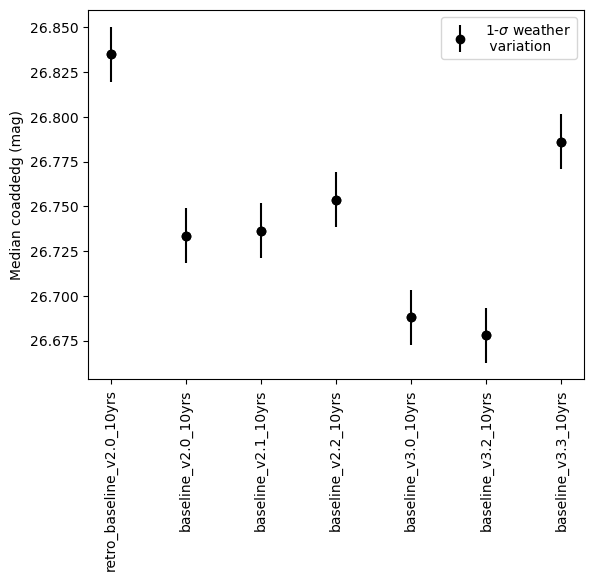

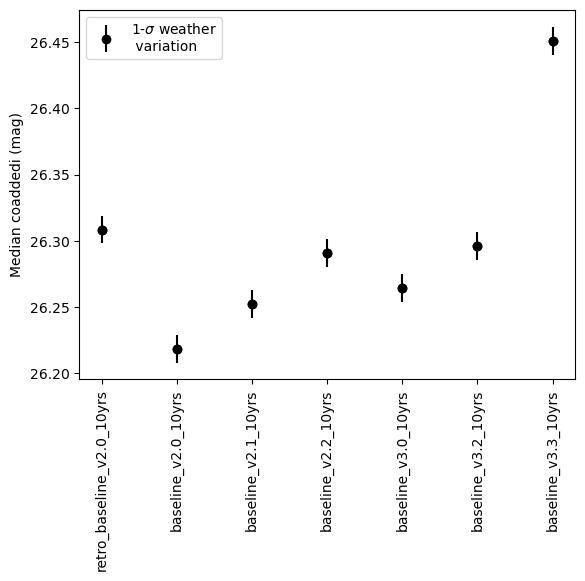

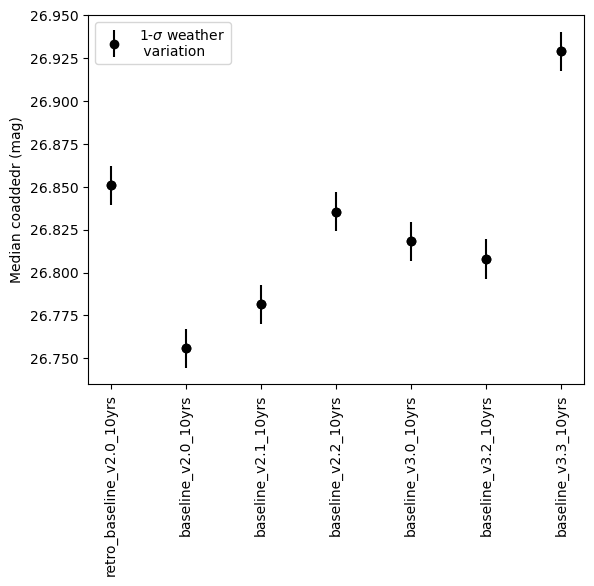

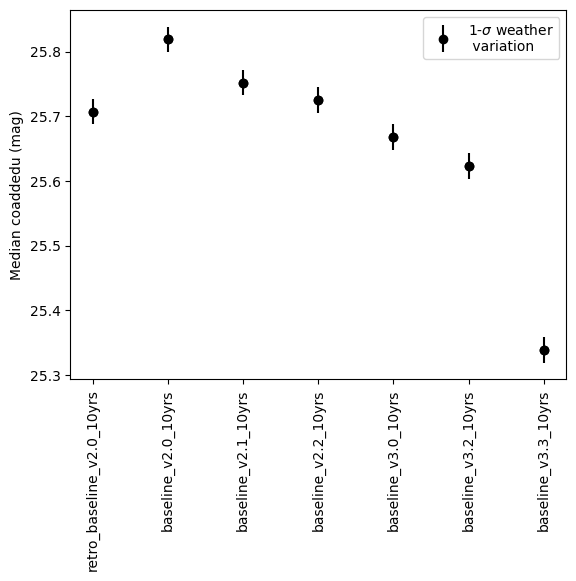

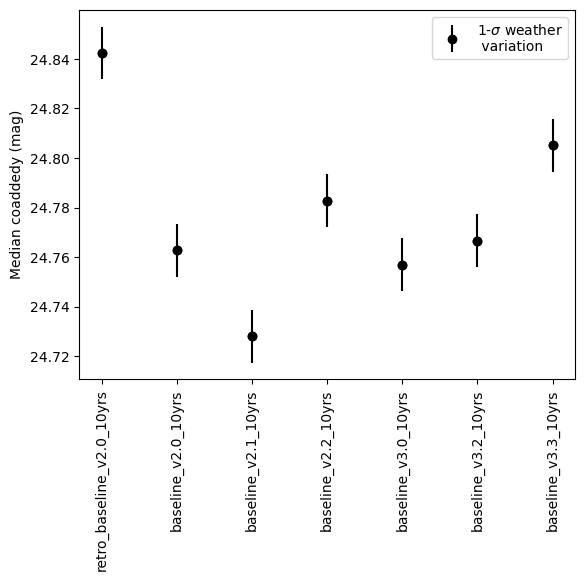

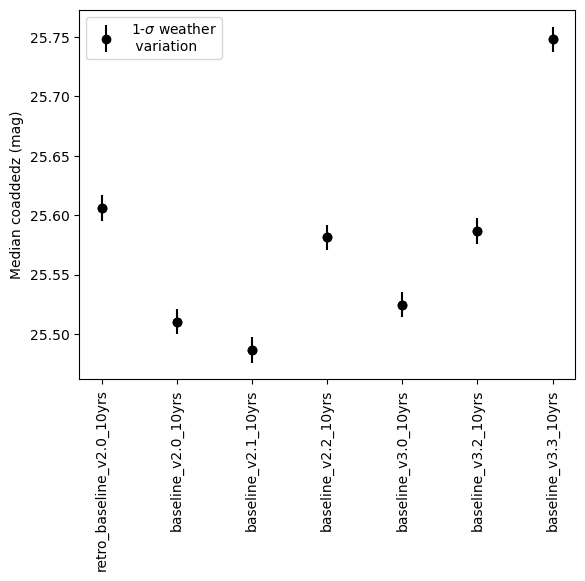

In [39]:
# Rough error bars from weather simulations

#col = data.columns[0]
for col in sub_mag.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_mag[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_mag[col].values.size), sub_mag[col], yerr=std_mag_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    
    label_add = ' (mag)'
    ax.set_ylabel('Median coadded' + col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])
